<a href="https://colab.research.google.com/github/pfescriva/Business-Science-Applied-AI/blob/main/TFM_Pere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilising LDA for topic modelling of URJC 2020 tweets
------------------------------------------------

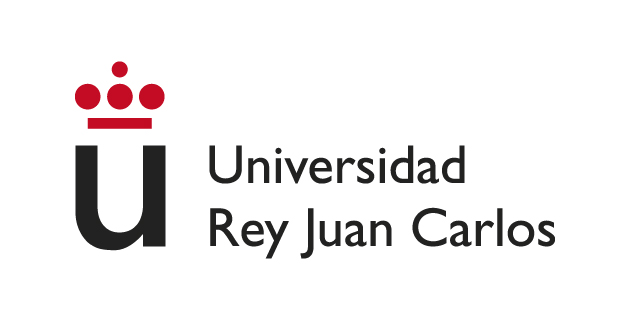

<br>

**The Notebook**

This notebooks attempts to make clear all the steps to indentify themes underlying tweets mentinoning URJC university alongside year 2020. The objective is to utilise TF-IDF scoring and LDA Topic Modelling. 

Note: Comments are provided for every step. On top the chunk is epxlained and coments are added to explain particular lines of code. 

<br>

**Process**

**1. [Load data and make basic cleaning](#Structure)**

**2. [Preprocessing I: (Tokenisation and text cleaning)](#Structure)**

**3. [Preprocessing II (Lemmatisation and stopwords removal) & TF-IDF Analysis](#Structure)**

**4. [Topic Modelling](#Structure)**

**5. [Conclussions](#Conclussions)**

**6. [Theory](#Structure)**

<br>

In [ ]:
# # !pip install indexer

# # !python3 -m pip install indexer

# # import indexer
# # import spellchecker

# # Import the dataset as data object

# ## The web scrapping gives the information as .json file. Therefore, we need to build a function that opens it and transforms to pandas df.  

# import json
# import pandas as pd
# import gzip

# def parse(path):
#   g = gzip.open(path, 'rb')
#   for l in g:
#     yield json.loads(l)

# def getDF(path):
#   i = 0
#   df = {}
#   for d in parse(path):
#     df[i] = d
#     i += 1
#   return pd.DataFrame.from_dict(df, orient = 'index') # {'text': 'string[pyarrow]'

# path = '/content/drive/MyDrive/TFM data/uam.jsonl.gz'
# data = getDF(path)

data = pd.read_pickle("/content/drive/MyDrive/TFM data/clean_data.pkl")



In [ ]:
data = data[data['tokens'].map(len) > 5]

In [ ]:

# 0. Some initial cleaning (Empty cols and constant cols)
data.dropna(how = 'all', axis = 1, inplace = True) # Drop empty columns
data = data.loc[:, (data != data.iloc[0]).any()]  # Drop Constant columns
print(data.shape[0])

# Filter out non-spanish documents
data = data.loc[(data['lang'] == "es")].reset_index(drop  = True)
print('First lang filter: ' + str(data.shape[0]))

# Keep only non RT information
data = data.loc[ ~ (data['text'].str.startswith('RT '))]
print('RT removal: ' + str(data.shape[0]))
# 
data = data.dropna(subset = ['text'])

419635
First lang filter: 289894
RT removal: 97989


In [ ]:
# 1. Drop duplicated documents that are writen by the same user, and laso drop any tweet that is NA (There were not anyway)
data = data.drop_duplicates(subset = ['author_id', 'text'], keep = 'first', inplace = False, ignore_index = False).reset_index(drop = True)
data = data.dropna(subset = ['text'])
print('Dropped duplicates and empty texts: ' + str(data.shape[0]))


Dropped duplicates and empty texts: 96980


In [198]:
# # Code to clean the workspace if needed (I needed it becuase of memory issues)
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

# Trabajo Fijo 

We first load required libraries to run the notebook. 

In [ ]:
# Code to load libraries:

!pip install mglearn
!pip install gensim
!pip install stop_words
!pip install pyLDAvis
!pip install langdetect
!pip install unidecode
!pip install pyspellchecker
# !pip install swifter

from spellchecker import SpellChecker # You need to install pyspellchecker and not spellchecker
# import swifter
import sklearn as sk
import pandas as pd 
import numpy as np 
import mglearn
from stop_words import get_stop_words
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
import warnings
from gensim.utils import simple_preprocess
from gensim import utils 
from collections import Counter
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from langdetect import detect
import spacy
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd

# Better computational efficiency for loops (apply, list compressions, for, while, etc.)
# import swifter


In [2]:
# https://ashutoshtripathi.com/2020/04/06/guide-to-tokenization-lemmatization-stop-words-and-phrase-matching-using-spacy/
path = '/content/drive/MyDrive/TFM data/urjc.jsonl.gz'
data = pd.read_json(path, lines = True)

In [3]:
!pip install swifter

In [ ]:
# Sometimes it gives an error... If so, load after reading json file. 
import swifter


Now duplicates, retweets, non-spanish documents and very short tweets will be removed from the corpus. 

As we proceed with the preprocessing we want to filter out documents we already know are too short. This will make more intensive functions (like lemaatisation) to work faster. 

In [5]:

# 0. Some initial cleaning (Empty cols and constant cols)
data.dropna(how = 'all', axis = 1, inplace = True) # Drop empty columns
data = data.loc[:, (data != data.iloc[0]).any()]  # Drop Constant columns
print(data.shape[0])

# Code below was thought to be a a possible solution, but in principle is not ideal to remove tweets that are replies.
# data = data[data['in_reply_to_user_id'].isnull()] 

# Filter out non-spanish documents
data = data.loc[(data['lang'] == "es")].reset_index(drop  = True)
print('First lang filter: ' + str(data.shape[0]))
del data['lang']

# Keep only non RT information
data = data.loc[~(data['text'].str.startswith('RT '))]
print('RT removal: ' + str(data.shape[0]))

# 1. Drop duplicated documents that are writen by the same user, and laso drop any tweet that is NA (There were not anyway)
# data = data.drop_duplicates(subset = ['author_id', 'text'], keep = 'first', inplace = False, ignore_index = False).reset_index(drop = True)
data = data.drop_duplicates(subset = ['text'], keep = 'first', inplace = False, ignore_index = False).reset_index(drop = True)
data = data.dropna(subset = ['text'])
print('Dropped duplicates and empty texts: ' + str(data.shape[0]))

# Some sure removals for speed (A twitter with not more than 14 characters including spaces won't be very useful)
data = data[data['text'].map(len) > 14]

# Filter out non-spanish documents with higher precission.
data['Language'] = data['text'].swifter.apply(detect)
data = data.loc[(data['Language'] == "es")].reset_index(drop = True)
print('First lang filter: ' + str(data.shape[0]))


171294
First lang filter: 162192
RT removal: 40699
Dropped duplicates and empty texts: 40562


Pandas Apply:   0%|          | 0/40548 [00:00<?, ?it/s]

First lang filter: 38229


## Processing I

First of all we need to leave the documents ready for lemmatization and stopwords removal. The order is not super neat, because some processing needs to be done before tokenisation and others after hashtags/mentions removal. Some steps are irrelevant where do them. 

For example, removing punctuation and signs is inteded to be done after hashtag removal.

At the botom of this part we will look for fixed phrases or pseudo hashtags.

In [6]:
"""
TOKENISE DOCUMENTS 
-------------------------------------------------------
This code aims at making all preprocessing steps required before lemmatisation. 
The stopwords removal is incomplete and will be done afterwards, since the objective here is 
just to remove stopwords to reduce computational work. 
Accents will also be removed afterwards. (I think lemmatisation would depend on the existence of accents)

Thinking of including stop biwords: puede ser, podria ser, llevar a cabo, etc.

Remove all characters that don't contain a list (Empty documents)

"""

from gensim.parsing.preprocessing import strip_punctuation

from gensim.parsing.preprocessing import strip_multiple_whitespaces
data['text'] = data['text'].apply(strip_multiple_whitespaces)

def unlist(x):
    x = ' '.join([word for word in x])
    return x 

# Maybe remove stop biwords or make them a word: llevar a cabo, buenos dias, buenas noches, formar parte, tener en cuenta? 


# 1. Remove some undersirable document components (urls, numbers, icons...) and tokenise
# --------------------------------------------------------------------------------------

def tokenise(x):
  """
  This function splits the string into words, but before doing so, I prefered to start 
  with some preprocessing steps 
  """

  # Probably a function that only picks alphabetical characters would be more effective
  # than focusing on removing specfic types of characters. There're some reasons not to do this 
  # and one is that it might be beneficial to do this sequentially. 
    
  def deEmojify(text): # Function to remove unconventional characters. 
    regrex_pattern = re.compile(pattern = "["
                                    u"\U0001F600-\U0001F64F"  # emoticons
                                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                    "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
    
  x = deEmojify(x)
  x = re.sub('hijos de p', "", x)
  x = re.sub('hijo de p', "", x)
  x = re.sub('hija de p', "", x)
  x = re.sub('hijas de p', "", x)
  x = re.sub('siguiente enlace', "", x)
  x = re.sub('siguiente link', "", x)
  x = re.sub('link', "", x)
  x = re.sub(r'[♂⬇❤🎥❗🥺✔️🤔🤦🏻‍♀️🤦♀️🧐➡️☺️✌️🤣⚠️✏️▶️¡!🥂⚖️🤩🤡🤯]', '', x)
  x = re.sub(r'urjc', '', x)
  x = re.sub(r'http\S+', '', x) # Remove links 
  x = re.sub(r'\d+', '', x) # remove numbers 
  x = str(np.char.lower(x))
  
  # tokenise
  x = x.split()
  
  # strip punctuation
  return x

data['tokens'] = data['text'].apply(tokenise)



# 2. Remove hashtags but also get rid of some left undesired components (jajas, metions, punctuation)
# ----------------------------------------------------------------------------------------------------

def hashtags(x): 
    
    x = [word for word in x if not word.startswith('#')]
    x = [word for word in x if '@' not in word] # Mentions and emails 
    x = [word for word in x if 'jaja' not in word]
    x = [word for word in x if 'jj' not in word]
    x = [word for word in x if 'haha' not in word]
    x = [word for word in x if 'jeje' not in word]
    x = [word for word in x if 'jiji' not in word]
    x = [word for word in x if 'aaa' not in word]
    x = [word for word in x if 'mmm' not in word]
    x = [word for word in x if 'sss' not in word]
    x = [word for word in x if 'hhh' not in word]
    x = [word for word in x if 'fff' not in word]
    x = [word for word in x if 'eee' not in word]
    x = [word for word in x if 'ooo' not in word]
    x = [word for word in x if 'uuu' not in word]
    x = [word for word in x if 'iii' not in word]
    x = [strip_punctuation(word) for word in x]
    
    def rematar(x): 
        x = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "", x)
        x = re.sub(r'[¿“”‘?’"„“<>,!¡"]', "", x)
        x = re.sub(' ', "", x)
        x = re.sub('cambiemos', "cambiar", x) # Small problem
        return x
    
    x = [rematar(word) for word in x]
    x = [word for word in x if len(str(word)) > 1]
    
    return x 

data['tokens'] = data['tokens'].apply(hashtags)


After preprocessing steps I show some random cases to check preprocessing qualities. This has been done decens of times and changes have been made. No additional inconsistencies in tokens are identified.

In [7]:
"""
VISUALISING (RANDOM) PREPROCESSED DOCUMENTS BEFORE LEMMATISATION
-------------------------------------------------------
This code aims at showing the quality of the preprocessing to detect possible flaws in 
the code not detected before, by selecting n random processed documents and displaying 
them against the originals.  
"""

# select number (n) of samples 
n = 10

# Show n items (Sample n in range without replacement)
import random
for i in random.sample(range(data.shape[0] + 1), n):
  print('')
  print('index ' + str(i))
  print('')
  print('Original sentence:')
  print('')
  print(' - ' + data['text'][i])
  print('')
  print('')
  print('Preprocessed tokens')
  print('')
  print(' - ' + str(data['tokens'][i]))
  print('')
  print('----------')
  print('')



index 10289

Original sentence:

 - Ah vale @urjc así que si quiero convalidarme una asignatura tengo que pagar 35 pavos por vuestra cara bonita además de pagar la matrícula de dicha asignatura..... sin palabras me dejáis


Preprocessed tokens

 - ['ah', 'vale', 'así', 'que', 'si', 'quiero', 'convalidarme', 'una', 'asignatura', 'tengo', 'que', 'pagar', 'pavos', 'por', 'vuestra', 'cara', 'bonita', 'además', 'de', 'pagar', 'la', 'matrícula', 'de', 'dicha', 'asignatura', 'sin', 'palabras', 'me', 'dejáis']

----------


index 28780

Original sentence:

 - El espíritu solidario también se mantiene gracias al proyecto “YoTeAyudoConTuBasura” llevado a cabo por los estudiantes del Máster en Asesoría jurídica Laboral y la profesora María Begoña Gil en colaboración con el ayuntamiento de Madrid. https://t.co/ISlzoaUq0S


Preprocessed tokens

 - ['el', 'espíritu', 'solidario', 'también', 'se', 'mantiene', 'gracias', 'al', 'proyecto', 'yoteayudocontubasura', 'llevado', 'cabo', 'por', 'los', 'estu

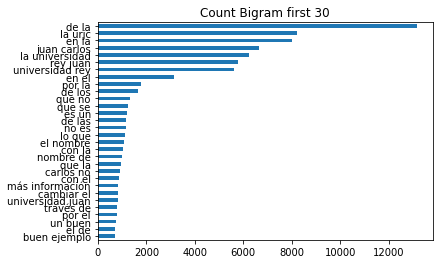

In [8]:
"""
PLOT MOST FREQUENT WORDS
Show how words are distributed before making any cleaning. This can enable us
to identify pseudo-hashtags. For example, 'vivir la experiencia URJC', which is not 
a topic but is an slogan that is refered to, often ironically. 
"""

# 1. Create the matrix with 2-word sequences and their frequencies en each document. 
tf_vectorizer = CountVectorizer(lowercase = True, min_df = 0.0005, ngram_range = (2,2))
tf = tf_vectorizer.fit_transform(data["tokens"].apply(lambda x: unlist(x)))
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

# 2. Ploot 
n = 30 # Define length of the graph
tfidf.apply(np.sum).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'Count Bigram first 30')


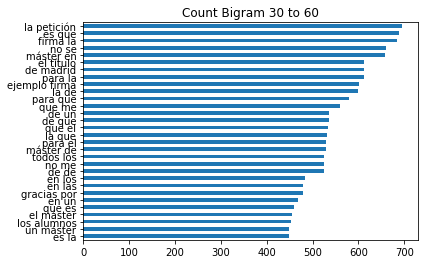

In [9]:
n = 60 # Define length of the graph
tfidf.apply(np.sum).sort_values(ascending = False)[30:n].sort_values(ascending = True).plot(kind = 'barh', title = 'Count Bigram 30 to 60')

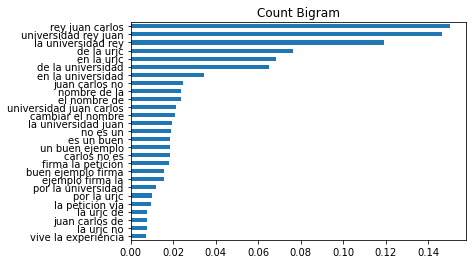

In [10]:

### Code to plot the cummulated TF-IDF unigram:
tf_vectorizer = CountVectorizer(lowercase = True, min_df = 0.0005, ngram_range = (3,3))
# CountVectorizer
tf = tf_vectorizer.fit_transform(data["tokens"].apply(lambda x: unlist(x)))
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 27 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'Count Bigram')


In [11]:
# show the rest
tfidf.apply(np.mean).sort_values(ascending = False)[30:80]

petición través de         0.006278
la petición través         0.006278
los de la                  0.006147
de la en                   0.005755
el título de               0.005624
la experiencia urjc        0.005336
la urjc es                 0.005258
un máster en               0.005205
juan carlos por            0.005127
de de la                   0.005049
máster en la               0.004944
el rector de               0.004918
profesor de la             0.004892
estudiantes de la          0.004865
carlos de madrid           0.004708
máster de la               0.004473
de la de                   0.004395
que la urjc                0.004368
del máster de              0.004342
cd móstoles urjc           0.004290
conectar con nuevxs        0.004185
con nuevxs compañerxs      0.004185
al siguiente grupo         0.004185
muchas ganas de            0.004185
la seguro que              0.004159
compañerxs únete al        0.004107
si quieres conectar        0.004107
nuevxs compañerxs únete    0

vivir experiencia, petición y cd mostoles, unete al 

In [12]:

for i in random.sample(range(269), n):
  print('-', data[data['tokens'].astype(str).str.contains("'vive', 'la', 'experiencia'")]['text'].reset_index(drop = True)[i])

- 9:00 Examen final 9:10 Mensaje de otro profesor informando de que se va a atrasar, que ya nos informarán 10:10 Seguimos sin saber nada VIVE LA EXPERIENCIA URJC
- Yo : Voy al baño y a por cafe o algo de la maquina La puerta de urgencias : cerrada El mostrador de urgencias : No hay nadie La sala de espera de urgencias : Hay gente Vive la experiencia hospital universitario urjc
- @ManoloBonete en fin vive la experiencia urjc
- vive la experiencia urjc: paga 1300€ de matrícula para buscarte tú la vida
- Vive la experiencia URJC https://t.co/fl6Xn1FC0O
- @yipeekigay Vive la Experiencia URJC
- vive la experiencia ✨ URJC ✨ https://t.co/mpkO4JiOCd
- Vive la experiencia URJC !! https://t.co/KhTgYKlMgP
- Vive la experiencia URJC https://t.co/ctWNFFT8My
- @elagaguiar_ vive la experiencia urjc
- vive la experiencia urjc :D
- @simplybrel Vive la experiencia URJC
- @putavidajdr Vive la experiencia urjc
- @javiblythe vive la experiencia urjc 🤪🤪🤪
- mi profesor: el rectorado ha decidido mover los exa

Vive la experiencia URJC does not add any information to the documents but needs to be removed to not cluster docuemnts with that slogan when they're actually speaking about other  themes. This is done after lemmatization and stopword removal (lemmatized docs containing vivr experiencia).

In [13]:
print(data[data['tokens'].astype(str).str.contains("'firma', 'la', 'petición'")]['text'].shape[0])
for i in random.sample(range(40), n):
  print(data[data['tokens'].astype(str).str.contains("'firma', 'la', 'petición'")]['text'].reset_index(drop = True)[i])

679
Cambiemos el nombre de la Universidad #ReyJuanCarlos no es un buen ejemplo - ¡Firma la petición! https://t.co/lURBn1Zyer vía @change_es @MiercolesRepubl
Cambiemos el nombre de la Universidad Rey Juan Carlos: no es un buen ejemplo - ¡Firma la petición! https://t.co/rLbIVlQcfj via @change_es es preferible ponerle de nombre El Dioni
Cambiemos el nombre de la Universidad Rey Juan Carlos: no es un buen ejemplo - ¡Firma la petición! https://t.co/nP6ZFbyQMe vía @change_es
La universidad rey Juan Carlos de Fuenlabrada: Presencialidad para la facultad de comunicación (Rey Juan Carlos de Fuenlabrada) - ¡Firma la petición! https://t.co/syosmnoxkO vía @change_es
Cambiemos el nombre de la Universidad Rey Juan Carlos: no es un buen ejemplo - ¡Firma la petición! https://t.co/6eNN8CqkdX vía @change_es
Cambiemos el nombre de la Universidad Rey Juan Carlos: no es un buen ejemplo - ¡Firma la petición! https://t.co/N6Tmw08mBs vía @change_es
Cambiemos el nombre de la Universidad Rey Juan Carlos: no es 

Here I decide to remove all these documents now. Since they're just duplicates but with different links. 



In [14]:
# I'm not 100% sure it's a good idea to remove them, since they're all in the same topic
print(data.shape)
data = data[~data['text'].str.contains("Cambiemos el nombre de la Universidad Rey Juan Carlos: no es un buen ejemplo - ¡Firma la petición!")]
print(data.shape)

(38229, 20)
(37632, 20)


In [15]:
print(data[data['tokens'].astype(str).str.contains("'cd', 'móstoles'")]['text'].shape[0])
for i in random.sample(range(40), n):
  print(' - ',data[data['tokens'].astype(str).str.contains("'cd', 'móstoles'")]['text'].reset_index(drop = True)[i])

138
 -  Según la web de la Federación, tenemos nuevo fichaje para el Benjamín A: Rubén Pulido que proviene del CD Móstoles URJC. cc @adnblancorm @javirverde https://t.co/xV0n3bgIvT
 -  Acabó la pretemporada para nuestra #playereleven @danabenitezzz con victoria frente al Electrocor Las Rozas 👏👏 ▶️ Ayer 30 mins de juego con el Senior B en la victoria al CD Móstoles URJC 🔥La próxima semana debut en liga del Juvenil @realmadridfem contra el CD Samper https://t.co/3sNAHjCBb8
 -  Va a dar comienzo la segunda mitad en el Municipal A.D. Arganda C.F. 0-0 C.D. Móstoles URJC Moraleja B https://t.co/4iUphy18EO 🔴🔴⚫⚽ #VAMOSARGANDA #SENTIMIENTOROJINEGRO
 -  Desde esta página dar la bienvenida y presentar nuestro apoyo total a la nueva peña Villafontana CD Móstoles URJC @VillafontanaII Juntos celebraremos las victorias de nuestro @CDMostoles Aupa azulon@s
 -  #Noticia / La Cruz Roja (@CruzRojaMostole) y el CD Móstoles URJC (@CDMostoles) recaudan fondos para financiar juguetes a las familias más vulne

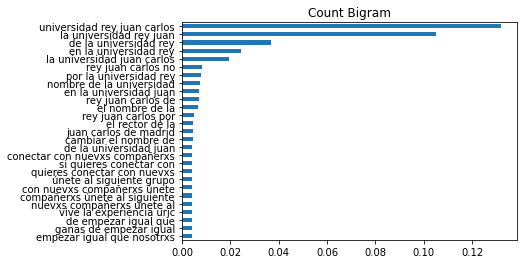

In [16]:

### Code to plot the cummulated TF-IDF unigram:
tf_vectorizer = CountVectorizer(lowercase = True, min_df = 0.0005, ngram_range = (4,4))
# CountVectorizer
tf = tf_vectorizer.fit_transform(data["tokens"].apply(lambda x: unlist(x)))
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 27 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'Count Bigram')


From these visuals we need to look deeper into some of them. What are they? How can we deal with them? For this purpuse we look into why these sentences are so frequent in the text. 

## Processing II

In [20]:
data = data[data['tokens'].map(len) > 4]
data['joint'] = data['tokens'].apply(unlist)

# Filter out non-spanish documents with higher precission.
print('Before: ' + str(data.shape[0]))
data['Language'] = data['joint'].swifter.apply(detect)
data = data.loc[(data['Language'] == "es")].reset_index(drop = True)
print('After: ' + str(data.shape[0]))
del data['joint']

Before: 28014


Pandas Apply:   0%|          | 0/28014 [00:00<?, ?it/s]

After: 26774


In [21]:

# 3. Light stopword removal 
# -------------------------
# We want to remove stopwords early because some processing stages are quite 
# expensive (Lemmatisation takes more than 45 mins...) and this makes it more efficient. 

stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

stop_words.extend(['hola', 'holi', 'si', 'no', 'eh', 'ehh', 'oh', 'ohh', 'hala', 'wow', 'aki', 'ke', 'qe', 'tmb', 'etc', 'vaya', 'jolin', 'bro', 'pibe', 'tete', 
                   'etcetera', 'waw', 'guau', '', ' ', 'buah', 'xe', 'jo', 'joder', 'fuck', 'fucking', 'ops', 'ups', 'yupi', 'claro', 'claaaro', 'ouch', 
                   'cabron', 'kabron', 'maricon', 'joder', 'flipo', 'flipas', 'xd', 'xdd', 'xdxd', 'traca', 'traya', 'https', 'omg', 'wtf', 'lmao', 'lol', 
                   'um', 'hmm', 'yuhu', 'puta', 'puto', 'pff', 'pfff', 'okei', 'oki', 'oks', 'ok', 'uf', 'uff', 'buff', 'quillo', 'killo', 'killos', 'illo', 'aun', 
                   'xq', 'xqe', 'macho', 'cagón', 'cagon', 'gilipoyas', 'pa', 'qe', 'ke', 'nah', 'yasss', 'venga', 'enga', 'crack', 'mismo', 'pues', 'parte'])

stop_words.extend(['ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xvii', 'xviii', 'xix', 'xx', 'xxi'])

stop_words.extend(['uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'once', 'doce', 'trece', 'catorce', 'quinze', 
                   'dieciseis', 'diecisiete', 'dieciocho', 'diecinueve', 'veinte', 'treinta', 'cuarenta', 'cincuenta', 'seseinta', 'seteinta', 'ochenta', 'noventa', 'cien', 'ciento',
                   'cientos', 'decenas', 'mil', 'miles', 'millon', 'millones', 'veintena', 'docena', 'docenas', 'centena', 'centenares'])

stop_words.extend(['poca', 'poco', 'bastante', 'mucho', 'mucha', 'tan', 'muchos', 'muchas', 'monton', 'muchísimo', 'muchísima', 'muchisima', 'muchisimas', 
                   'muchisimo', 'muchisimos', 'muchísimos', 'muchísimas', 'varios', 'varias', 'gran', 'co'])

stop_words.extend(['universidad', 'rey', 'juan', 'carlos', 'golpe', 'urjc', 'uni', 'juanca', 'juancar', 'juancarlos'])

stop_words.extend(['quizas', 'quiza', 'probablemente', 'seguramente', 'mejor', 'probable', 'parte', 'posible', 'posiblemente', 
                   'tranquilamente', 'literalmente', 'después', 'despues', 'nunca', 'siempre', 'posteriormente', 'mientras', 'ademas', 
                   'además', 'mas', 'cosa', 'cosas', 'totalmente', 'completamente', 'todo', 'perfectamente'])

stop_words.extend(['gracias', 'vía', 'través', 'mediante', 'asi', 'así', 'fué', 'sido', 'via', 'parte', 'cuyo', 'cuya', 'cuyos', 'cuyas', 'cual', 'sino'])
stop_words.extend(['aquí', 'ahi', 'aun', 'mí', 'tí', 'él', 'li', 'cómo', 'hace', 'hacer', 'digo', 'va', 'es', 'se', 'ser', 'estan', 'ven', 'venid', 'vente', 
                   'voy', 'vas', 'van', 'ver', 'verás', 'conmigo'])

stop_words.extend(['vosotrxs', 'nosotrxs', 'ellxs'])

stop_words.extend(stopwords.words('english')) # A veces usamos palabras en inglés. Estas pueden ser relevantes o no, en cualquier caso, no lo sería las stopwords seguro
english_add = ['great', 'good', 'bad', 'do', 'think', 'date', 'first', 'second', 'third', 'one', 'two', 'three', 'four', 'five', 'latest']
stop_words.extend(english_add)


def remove_stopwords(x, stop_words):
    x = [word for word in x if not word in stop_words]
    return x

# stop_words_new = copy.deepcopy(stop_words)     
data['tokens'] = data['tokens'].apply(lambda x: remove_stopwords(x, stop_words))

data = data[data['tokens'].map(len) > 4]

# Remove tweets that say the same and that are not spanish with higher precision
def unlist(x):
    x = ' '.join([word for word in x])
    return x 

# data['tokens_fullstring'] = data['tokens'].apply(unlist)
# data = data.drop_duplicates(subset = 'tokens_fullstring')
# del data['tokens_fullstring']

data = data.reset_index(drop = True)

In [22]:
!python -m spacy download es
nlp = spacy.load('es')

     |████████████████████████████████| 16.2 MB 6.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [23]:
"""
LEMMATISATION AND ACCENT REMOVAL
"""

import warnings
warnings.filterwarnings("ignore")

def lemmatizer(text, exceptions):  
  x = [nlp(word)[0].lemma_ for word in text if word not in exceptions]
  return x

# exceptions are included because for example, casada became casar, and titulo because titular, etc.
exceptions = ['casa', 'caso', 'grado', 'casado', 'título', 'titulo', 'curso', 'mayo', 'proyecto', 'calle', 'piso', 'centro', 'correo', 'cara']
data['lemmatized'] = data['tokens'].swifter.apply(lambda x: lemmatizer(x, exceptions)) 

import unidecode
def accents(x): 
    x = [unidecode.unidecode(word) for word in x]
    x = [gensim.utils.deaccent(word) for word in x]
    return x 

# import unidecode
data['lemmatized'] = data['lemmatized'].apply(accents)


Pandas Apply:   0%|          | 0/26774 [00:00<?, ?it/s]

In [39]:
print(data.shape)

def removement_vivirexperiencia(x): 
  if "'vivir', 'experiencia'" in str(x):
    x = [word for word in x if 'vivir' != word]
    x = [word for word in x if 'experiencia' != word]
  return x

data['lemmatized'] = data['lemmatized'].apply(removement_vivirexperiencia)

(26774, 21)


In [40]:
"""
VISUALISING PREPROCESSED DOCUMENTS AFTER LEMMATISATION (UNCOMPLETED STOPWORD REMOVAL)
--------------------------------------------------------------------------------------
This code aims at showing the quality of the preprocessing to detect possible flaws in 
the code not detected before, by selecting n random processed documents and displaying 
them against the originals.  
"""

# select number (n) of samples 
n = 10

# Show n items 
for i in random.sample(range(data.shape[0] + 1), n):
  print('')
  print('index ' + str(i))
  print('')
  print('Original sentence:')
  print('')
  print(' - ' + data['text'][i])
  print('')
  print('')
  print('Preprocessed tokens')
  print('')
  print(' - ' + str(data['lemmatized'][i]))
  print('')
  print('----------')
  print('')



index 8327

Original sentence:

 - Quien doble grado de ade y derecho en la urjc? De primer año #queydondeestudiar2020


Preprocessed tokens

 - ['doblar', 'adir', 'derecho', '1', 'ano']

----------


index 7175

Original sentence:

 - Ya puedo decir que soy Profesor de Universidad con evaluación Excelente en el Programa DOCENTIA. Han sido 3 años formándome, mejorando día a día y creando proyectos de innovación docente por y para la mejora del alumnado de la @urjc Estoy FELIZ 😀


Preprocessed tokens

 - ['poder', 'decir', 'profesor', 'evaluacion', 'excelente', 'programar', 'docentia', 'ano', 'formandome', 'mejorar', 'dia', 'dia', 'crear', 'proyecto', 'innovacion', 'docente', 'mejorar', 'alumnado', 'feliz']

----------


index 21155

Original sentence:

 - "La Clínica Universitaria de la URJC sigue prestando servicio a los pacientes durante el confinamiento" https://t.co/RmaLvlrByB


Preprocessed tokens

 - ['clinico', 'universitario', 'seguir', 'prestar', 'servicio', 'paciente', 'conf

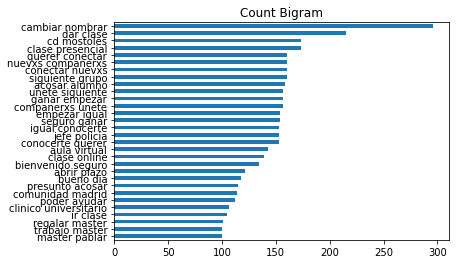

In [41]:
"""
PLOT MOST FREQUENT WORDS
Show how words are distributed before making any cleaning. This can enable us
to identify pseudo-hashtags. For example, 'vivir la experiencia URJC', which is not 
a topic but is an slogan that is refered to, often ironically. 
"""

# 1. Create the matrix with 2-word sequences and their frequencies en each document. 
tf_vectorizer = CountVectorizer(lowercase = True, min_df = 0.0005, ngram_range = (2,2))
tf = tf_vectorizer.fit_transform(data["lemmatized"].apply(lambda x: unlist(x)))
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

# 2. Ploot 
n = 30 # Define length of the graph
tfidf.apply(np.sum).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'Count Bigram')


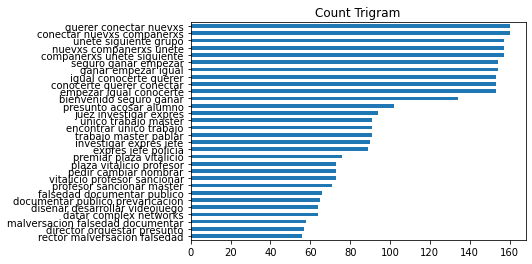

In [42]:
"""
PLOT MOST FREQUENT WORDS
Show how words are distributed before making any cleaning. This can enable us
to identify pseudo-hashtags. For example, 'vivir la experiencia URJC', which is not 
a topic but is an slogan that is refered to, often ironically. 
"""

# 1. Create the matrix with 2-word sequences and their frequencies en each document. 
tf_vectorizer = CountVectorizer(lowercase = True, min_df = 0.0005, ngram_range = (3,3))
tf = tf_vectorizer.fit_transform(data["lemmatized"].apply(lambda x: unlist(x)))
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

# 2. Ploot 
n = 30 # Define length of the graph
tfidf.apply(np.sum).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'Count Trigram')


In [43]:

stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

verbs = ['hacer', 'ir', 'haced', 'hacerte', 'ser', 'poner', 'ver', 'creer', 'dar', 'poder']
stop_words.extend(verbs)

further = ['poca', 'poco', 'poquito', 'poquitin', 'pelin', 'bueno', 'interesante', 'gracias', 'dias', 'dia', 'algun', 'alguno', 'alguna', 'pon', 'mejor', 'menos', 'peor', 'nuevo', 'href', 'ano', 'via', 'tal', 
          'alguien', 'cada', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'quizas', 'quiza', 'nada', 'nunca', 'mismisimo', '',
          'bien', 'solo', 'solamente', 'vez', 'echale']
stop_words.extend(further)

stop_words.extend(['informacion', 'info', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'primerisima', 'master'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
# puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver,
extras = ['seguro', 'bueno', 'realizar', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']

# stop_words_new = copy.deepcopy(stop_words)     
data['lemmatized'] = data['lemmatized'].apply(lambda x: remove_stopwords(x, stop_words))



In [44]:
"""
VISUALISING PREPROCESSED DOCUMENTS AFTER LEMMATISATION & WORD REMOVAL
---------------------------------------------------------------------
"""

# select number (n) of samples 
n = 5

# Show n items 
for i in random.sample(range(data.shape[0] + 1), n):
  print('')
  print('index ' + str(i))
  print('')
  print('Original sentence:')
  print('')
  print(' - ' + data['text'][i])
  print('')
  print('')
  print('Preprocessed tokens')
  print('')
  print(' - ' + str(data['lemmatized'][i]))
  print('')
  print('----------')
  print('')



index 16111

Original sentence:

 - Abierta convocatoria del Grupo Compostela de Universidades para profesores que quieran participar en intercambios virtuales VE-COIL entre agosto y diciembre. Todo el PDI de la @urjc puede participar https://t.co/ANw5okE6gc


Preprocessed tokens

 - ['abrir', 'convocatorio', 'grupo', 'compostela', 'querer', 'participar', 'intercambio', 'virtual', 'vecoil', 'agostar', 'diciembre', 'pdi', 'participar']

----------


index 22139

Original sentence:

 - El programa "Voces de Oro" ya está en directo en RADIO URJC. Podéis escucarlo a través de https://t.co/opD4Z8h6Rf.


Preprocessed tokens

 - ['programar', 'voz', 'orar', 'directo', 'radiar', 'escucarlo']

----------


index 12788

Original sentence:

 - José Manuel Tuero Sánchez es profesor y supervisor de Másters en Derecho Penal Económico de la Universidad Rey Juan Carlos. Hijo de Manuel Antonio Tuero Madiedo, ex Gran Maestre de la Gran Logia Federal de España y abogado defensor de Ghaleb (AlQaeda) y Ou

# 3. N-Grams Analysis

## Unigrams

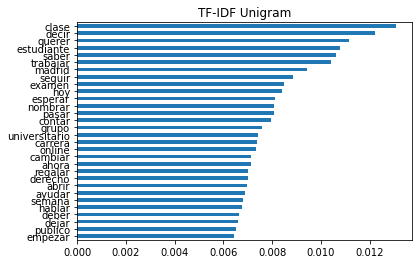

In [45]:

### Code to plot the cummulated TF-IDF unigram:
tf_vectorizer = TfidfVectorizer(lowercase = True, min_df = 0.0005)
tf = tf_vectorizer.fit_transform(data["lemmatized"].apply(lambda x: unlist(x)))
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 30 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'TF-IDF Unigram')


Pandas Apply:   0%|          | 0/2699 [00:00<?, ?it/s]

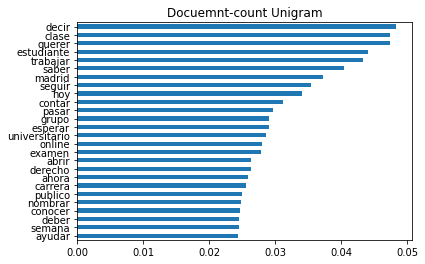

In [46]:
""" 
WORD FRQUENCY UNIGRAM
The graph displays the % of documents with that word
"""

def freq(x): 
  if x != 0: 
    x = 1
  return x

n = 26
tfidf.swifter.apply(lambda x: np.mean(x.apply(lambda x: freq(x)))).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'Docuemnt-count Unigram')


## Bigrams

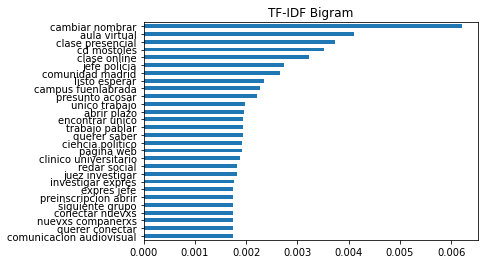

In [47]:
# CountVectorizer
tf_vectorizer = TfidfVectorizer(lowercase = True, min_df = 0.0002, ngram_range = (2,2))
tf = tf_vectorizer.fit_transform(data["lemmatized"].apply(lambda x: unlist(x)))
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 28 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'TF-IDF Bigram')


Pandas Apply:   0%|          | 0/3039 [00:00<?, ?it/s]

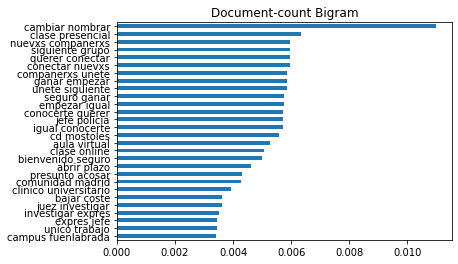

In [48]:
tfidf.swifter.apply(lambda x: np.mean(x.apply(lambda x: freq(x)))).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'Document-count Bigram')

## Trigram

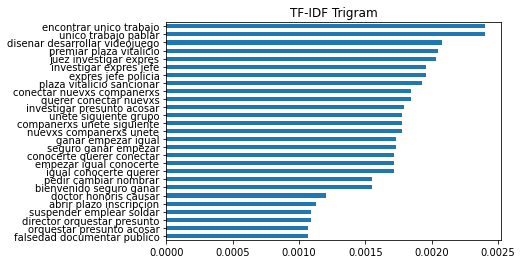

In [49]:

# CountVectorizer
tf_vectorizer = TfidfVectorizer(lowercase = True, min_df = 0.0002, ngram_range = (3,3))
tf = tf_vectorizer.fit_transform(data["lemmatized"].apply(lambda x: unlist(x)))
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 27 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'TF-IDF Trigram')


Pandas Apply:   0%|          | 0/1089 [00:00<?, ?it/s]

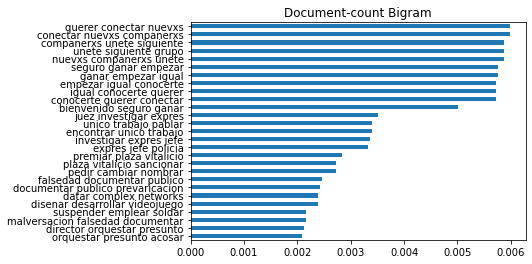

In [50]:

tfidf.swifter.apply(lambda x: np.mean(x.apply(lambda x: freq(x)))).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'Document-count Bigram')


## Four-gram

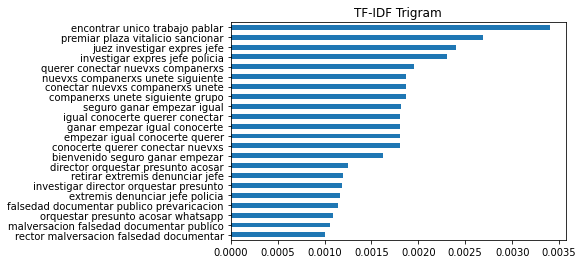

In [51]:

# CountVectorizer
tf_vectorizer = TfidfVectorizer(lowercase = True, min_df = 0.0002, ngram_range = (4,4))
tf = tf_vectorizer.fit_transform(data["lemmatized"].apply(lambda x: unlist(x)))
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 22 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'TF-IDF Trigram')


Pandas Apply:   0%|          | 0/683 [00:00<?, ?it/s]

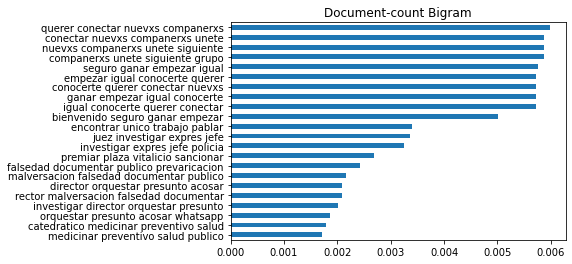

In [52]:

tfidf.swifter.apply(lambda x: np.mean(x.apply(lambda x: freq(x)))).sort_values(ascending = False)[0:n].sort_values(ascending = True).plot(kind = 'barh', title = 'Document-count Bigram')


# Topic Modelling 

## Pilot model to evaluate preprocessing 


In [53]:
"""
CONVERTING PROCESSED DATA TO SUIT THE MODELLING FUNCTION: 


"""


def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))

# Remove documents with 3 words or less than length 4:
tokens = data[data['lemmatized'].map(len) > 3]

# Group by author
tokens['tokens'] = tokens['lemmatized'].apply(lambda x: ' '.join(x))
author = tokens.groupby('author_id')['tokens', 'text'].agg(lambda x: ' '.join(map(str, x))).reset_index()
author['tokens'] = list(sent_to_words(author['tokens']))

# Filter extremes
id2word = Dictionary(author['tokens'], prune_at = 1000000)
id2word.filter_extremes(no_below = 2, no_above = 0.95, keep_n = None)

# Create Corpus
texts = list(sent_to_words(author['tokens']))
# texts = [item for item in texts if len(item) >= 4]

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [54]:
"""
PILOT LDA to anticipate flaws in the preprocessing step
"""

warnings.filterwarnings("ignore")
model = LdaMulticore(corpus = corpus, id2word = id2word, num_topics = 12, iterations = 40, random_state = 10,
                                                    workers = 5)

print('LDA Model:')
print('')
for i in range(0, 12):
  print('Topic ' + str(i + 1) +  ': ', model.print_topics()[i])
print('')

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)


LDA Model:

Topic 1:  (0, '0.008*"clase" + 0.007*"estudiante" + 0.006*"docente" + 0.006*"decir" + 0.006*"implantologia" + 0.006*"derecho" + 0.006*"contar" + 0.005*"trabajar" + 0.005*"ayudar" + 0.005*"oral"')
Topic 2:  (1, '0.015*"querer" + 0.009*"saber" + 0.007*"trabajar" + 0.006*"decir" + 0.006*"estudiante" + 0.006*"ingenieria" + 0.005*"grupo" + 0.005*"aprender" + 0.005*"derecho" + 0.004*"mostoles"')
Topic 3:  (2, '0.008*"grupo" + 0.007*"contar" + 0.006*"madrid" + 0.005*"trabajar" + 0.005*"estudiante" + 0.005*"saber" + 0.004*"clase" + 0.004*"semana" + 0.004*"campus" + 0.004*"universitario"')
Topic 4:  (3, '0.008*"madrid" + 0.007*"trabajar" + 0.006*"universitario" + 0.006*"estudiante" + 0.005*"seguir" + 0.004*"plaza" + 0.004*"abrir" + 0.003*"publico" + 0.003*"grupo" + 0.003*"clase"')
Topic 5:  (4, '0.005*"madrid" + 0.005*"jornada" + 0.005*"covid" + 0.005*"llegar" + 0.004*"clase" + 0.004*"universitario" + 0.004*"formar" + 0.004*"trabajar" + 0.003*"ayudar" + 0.003*"abrir"')
Topic 6:  (5,

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.010045 -0.027500       1        1  10.775608
2     -0.003559  0.021782       2        1  10.352887
5     -0.012629 -0.008838       3        1  10.209050
8      0.003761 -0.019256       4        1   9.454893
4     -0.037919  0.013912       5        1   8.937420
11     0.005616 -0.014203       6        1   8.235116
3     -0.010454 -0.005256       7        1   7.984273
1      0.033494 -0.002982       8        1   7.706504
7      0.001090 -0.010083       9        1   7.284986
9      0.003324 -0.043396      10        1   6.790569
6      0.061120  0.054654      11        1   6.370604
0     -0.053890  0.041165      12        1   5.898089, topic_info=               Term         Freq        Total Category  logprob  loglift
747          querer  1281.000000  1281.000000  Default  30.0000  30.0000
9048  implantologia   152.000000   152.000000  Default  29.0000  29.0000
4934           oral   165.000000   165.000000  Default  28.0000  28.0000
6174        cirugia   177.000000   177.000000  Default  27.0000  27.0000
150           grupo   920.000000   920.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
748           saber    53.422386  1073.717336  Topic12  -5.6169  -0.1701
150           grupo    42.408094   920.208586  Topic12  -5.8477  -0.2467
796        personar    40.585196   629.620541  Topic12  -5.8917   0.0888
759         carrera    40.835888   745.511460  Topic12  -5.8855  -0.0740
747          querer    42.859162  1281.029491  Topic12  -5.8372  -0.5670

[962 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
7953      7  0.747051  abolicion
9647      3  0.093795     abolir
9647      9  0.844155     abolir
227       1  0.059311      abrir
227       2  0.132743      abrir
...     ...       ...        ...
4815      1  0.696499     zapato
4815      4  0.116083     zapato
8495      6  0.146717         zp
8495     10  0.733585         zp
6104      1  0.766622      zurdo

[3988 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 3, 6, 9, 5, 12, 4, 2, 8, 10, 7, 1])

In [51]:
# Stopwords extend if needed. 

# Possible stopwords: bueno, seguir, estudiante, clase, realizar

In [55]:
# Try again

stop_words.extend(['bueno', 'querer', 'saber', 'decir', 'esperar', 'mismisimo', 'esperar'])


In [56]:
# stop_words_new = copy.deepcopy(stop_words)     
data['lemmatized'] = data['lemmatized'].apply(lambda x: remove_stopwords(x, stop_words))

# Remove documents with 3 words or less than length 4:
tokens = data[data['lemmatized'].map(len) > 3]

# Group by author
tokens['tokens'] = tokens['lemmatized'].apply(lambda x: ' '.join(x))
author = tokens.groupby('author_id')['tokens', 'text'].agg(lambda x: ' '.join(map(str, x))).reset_index()
author['tokens'] = list(sent_to_words(author['tokens']))

# Filter extremes
id2word = Dictionary(author['tokens'], prune_at = 100000000)
id2word.filter_extremes(no_below = 3, no_above = 1, keep_n = None)

# Create Corpus
texts = list(sent_to_words(author['tokens']))
texts = [item for item in texts if len(item) >= 4]

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [57]:
"""
FAKE LDA to anticipate flaws in the preprocessing step
"""

warnings.filterwarnings("ignore")
model = LdaMulticore(corpus = corpus, num_topics = 10, id2word = id2word, iterations = 40, random_state = 10,
                                                    workers = 5)

print('LDA Model:')
print('')
for i in range(0, 10):
  print('Topic ' + str(i + 1) +  ': ', model.print_topics()[i])
print('')


pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)

# Possible stopwords: bueno, seguir, estudiante, clase


LDA Model:

Topic 1:  (0, '0.008*"clase" + 0.007*"estudiante" + 0.007*"online" + 0.005*"hablar" + 0.005*"examen" + 0.005*"madrid" + 0.005*"publico" + 0.004*"universitario" + 0.004*"dejar" + 0.004*"hoy"')
Topic 2:  (1, '0.009*"madrid" + 0.006*"pablar" + 0.005*"publico" + 0.004*"hoy" + 0.004*"investigacion" + 0.004*"espana" + 0.004*"trabajar" + 0.004*"clase" + 0.004*"estudiante" + 0.004*"llamar"')
Topic 3:  (2, '0.010*"estudiante" + 0.006*"grupo" + 0.005*"contar" + 0.005*"hablar" + 0.005*"madrid" + 0.004*"desarrollar" + 0.004*"ahora" + 0.004*"hoy" + 0.004*"sacar" + 0.004*"regalar"')
Topic 4:  (3, '0.009*"trabajar" + 0.007*"grupo" + 0.007*"pasar" + 0.006*"derecho" + 0.005*"estudiante" + 0.005*"empezar" + 0.005*"carrera" + 0.004*"hoy" + 0.004*"clase" + 0.004*"aprender"')
Topic 5:  (4, '0.006*"trabajar" + 0.006*"contar" + 0.006*"seguir" + 0.006*"educacion" + 0.006*"deber" + 0.006*"madrid" + 0.005*"examen" + 0.005*"clase" + 0.004*"parecer" + 0.004*"ayudar"')
Topic 6:  (5, '0.010*"madrid" + 0

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.028239  0.007934       1        1  14.033062
6     -0.030845 -0.003921       2        1  12.505322
9     -0.021880  0.000066       3        1  12.328655
2      0.007932  0.015980       4        1  10.880892
0     -0.010448  0.028640       5        1  10.574972
8     -0.015461  0.036838       6        1   9.093221
4     -0.013782 -0.001829       7        1   8.869087
1     -0.011588 -0.020564       8        1   8.323337
5     -0.000916 -0.064253       9        1   6.956294
7      0.068750  0.001108      10        1   6.435156, topic_info=          Term         Freq        Total Category  logprob  loglift
5263   cirugia   214.000000   214.000000  Default  30.0000  30.0000
4382      oral   202.000000   202.000000  Default  29.0000  29.0000
53      madrid  1172.000000  1172.000000  Default  28.0000  28.0000
36     cambiar   557.000000   557.000000  Default  27.0000  27.0000
162   mostoles   609.000000   609.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
250      dejar    42.393566   684.355498  Topic10  -5.8875  -0.0381
13      hablar    40.042614   649.145429  Topic10  -5.9445  -0.0423
1075   derecho    39.347756   691.474073  Topic10  -5.9620  -0.1230
501      mesar    36.982496   384.090145  Topic10  -6.0240   0.4030
53      madrid    38.366298  1172.823239  Topic10  -5.9873  -0.6766

[812 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
222       1  0.131944   abrir
222       2  0.257086   abrir
222       3  0.088416   abrir
222       4  0.080254   abrir
222       5  0.096577   abrir
...     ...       ...     ...
4296      4  0.691350  zapato
4296      5  0.115225  zapato
4296      7  0.115225  zapato
6586      3  0.765902      zp
6586      7  0.127650      zp

[3540 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 10, 3, 1, 9, 5, 2, 6, 8])

In [58]:
stop_words.extend(['partir']) 

## Narrow down the number of topics

In [59]:
# Code to check quicly the possible quality of the application. 

""" 
This code reflects:

You will have indicated the step by numeric definition (1., 2., etc) in a # comment.
The hipermarameters that are adjusted will be commented (#) in the same line they're used. 
"""

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

# Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
def remove_stopwords(texts, stop_words_new):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]

# Function replicating sklearn pipeline gridsearch

alphas = [0.25, 0.5, 0.75]
etas = [0.25, 0.5, 0.75]
k = range(2, 26)

def gensim_gridsearch(data, alphas, etas, k):
        
    coherence_values = []
    model_list = []
    parameters = pd.DataFrame(columns = ['alpha', 'eta', 'num_topics'])
    
    # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
    for alpha in alphas:
      for eta in etas:
        for num_topics in k:
          parameters.loc[-1] = [alpha, eta, num_topics]
          parameters.index = parameters.index + 1
                                
          model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
                                                    workers = 5)
                                
          model_list.append(model)
          coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
          coherence_values.append(coherencemodel.get_coherence())
                                
          print(alpha, eta, num_topics)
                               
        
    parameters['Score'] = coherence_values
    # parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

    return model_list, coherence_values, parameters


In [ ]:

import warnings
warnings.filterwarnings("ignore")

model_list, coherence_values, parameters = gensim_gridsearch(data, alphas, etas, k)


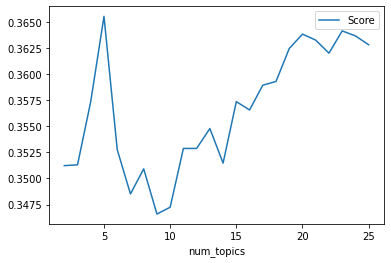

In [62]:

topics = parameters.groupby('num_topics')['Score'].max().reset_index(drop = False)

plot = topics.plot('num_topics', 'Score')


## Grid search

The k values chosen are: 7, 15, 19

In [ ]:

warnings.filterwarnings("ignore")

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
etas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
k = [5, 20]

model_list_2, coherence_values_2, parameters_2 = gensim_gridsearch(data, alphas, etas, k)


0.1 0.1 5
0.1 0.1 20
0.1 0.2 5
0.1 0.2 20
0.1 0.3 5
0.1 0.3 20
0.1 0.4 5
0.1 0.4 20
0.1 0.5 5
0.1 0.5 20
0.1 0.6 5
0.1 0.6 20
0.1 0.7 5
0.1 0.7 20
0.1 0.8 5
0.1 0.8 20
0.1 0.9 5
0.1 0.9 20
0.2 0.1 5
0.2 0.1 20
0.2 0.2 5
0.2 0.2 20
0.2 0.3 5
0.2 0.3 20
0.2 0.4 5
0.2 0.4 20
0.2 0.5 5
0.2 0.5 20
0.2 0.6 5
0.2 0.6 20
0.2 0.7 5
0.2 0.7 20
0.2 0.8 5
0.2 0.8 20
0.2 0.9 5
0.2 0.9 20
0.3 0.1 5
0.3 0.1 20
0.3 0.2 5
0.3 0.2 20
0.3 0.3 5
0.3 0.3 20
0.3 0.4 5
0.3 0.4 20
0.3 0.5 5
0.3 0.5 20
0.3 0.6 5
0.3 0.6 20
0.3 0.7 5
0.3 0.7 20
0.3 0.8 5
0.3 0.8 20
0.3 0.9 5
0.3 0.9 20
0.4 0.1 5
0.4 0.1 20
0.4 0.2 5
0.4 0.2 20
0.4 0.3 5
0.4 0.3 20
0.4 0.4 5
0.4 0.4 20
0.4 0.5 5
0.4 0.5 20
0.4 0.6 5
0.4 0.6 20
0.4 0.7 5
0.4 0.7 20
0.4 0.8 5
0.4 0.8 20
0.4 0.9 5
0.4 0.9 20
0.5 0.1 5
0.5 0.1 20
0.5 0.2 5
0.5 0.2 20
0.5 0.3 5
0.5 0.3 20
0.5 0.4 5
0.5 0.4 20
0.5 0.5 5
0.5 0.5 20
0.5 0.6 5
0.5 0.6 20
0.5 0.7 5
0.5 0.7 20
0.5 0.8 5
0.5 0.8 20
0.5 0.9 5
0.5 0.9 20
0.6 0.1 5
0.6 0.1 20
0.6 0.2 5
0.6 0.2 20
0.6 0.3 5
0.6

In [88]:
parameters['Score'].max()

0.3528048311019563

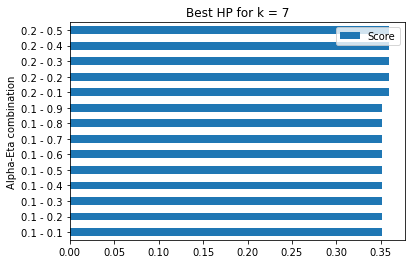

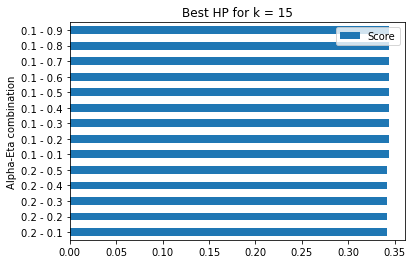

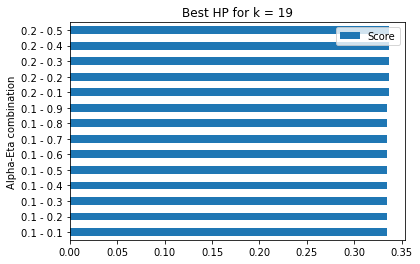

In [91]:
"""
BEST MODELS BY K:
This code shows the top-10 alpha-eta combinations based on the Coeherence Score. 
"""

parameters_2['Alpha-Eta combination'] = parameters_2['alpha'].astype(str) + ' - ' + parameters_2['eta'].astype(str)

for i in parameters_2['num_topics'].unique(): 

  x = parameters_2[parameters_2['num_topics'] == i]
  x.index = x['Alpha-Eta combination']
  del x['alpha']
  del x['eta']
  del x['num_topics']

  x[0:14].sort_values(by = ['Score'], ascending = True).plot(kind = 'barh', title = 'Best HP for k = ' + str(int(i)))



## Model selection



### 1.1

In [93]:
"""
FAKE LDA to anticipate flaws in the preprocessing step
"""

k = 7

model = LdaMulticore(corpus = corpus, num_topics = k, alpha = 0.2, eta = 0.5, id2word = id2word, iterations = 100, random_state = 10,
                                                    workers = 5)

print('LDA Model:')
print('')
for i in range(0, k):
  print('Topic ' + str(i + 1) +  ': ', model.print_topics()[i])
print('')

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)
vis

# Possible stopwords: bueno, seguir, estudiante, clase, 'querer', 


LDA Model:

Topic 1:  (0, '0.005*"trabajar" + 0.005*"derecho" + 0.005*"mostoles" + 0.005*"online" + 0.004*"pagar" + 0.004*"seguir" + 0.004*"mismo" + 0.004*"universitario" + 0.003*"aprender" + 0.003*"tiempo"')
Topic 2:  (1, '0.007*"hoy" + 0.006*"estudiante" + 0.006*"hablar" + 0.005*"clase" + 0.004*"jornada" + 0.004*"deber" + 0.004*"trabajar" + 0.004*"seguir" + 0.003*"derecho" + 0.003*"universitario"')
Topic 3:  (2, '0.007*"madrid" + 0.006*"trabajar" + 0.006*"mostoles" + 0.006*"pasar" + 0.004*"ahora" + 0.004*"estudiante" + 0.004*"personar" + 0.004*"campus" + 0.004*"gente" + 0.003*"espana"')
Topic 4:  (3, '0.008*"clase" + 0.007*"examen" + 0.005*"madrid" + 0.005*"carrera" + 0.005*"seguir" + 0.004*"pasar" + 0.004*"ahora" + 0.003*"regalar" + 0.003*"mismo" + 0.003*"problema"')
Topic 5:  (4, '0.007*"trabajar" + 0.006*"universitario" + 0.006*"clase" + 0.005*"contar" + 0.004*"mandar" + 0.004*"sacar" + 0.004*"madrid" + 0.004*"abrir" + 0.004*"investigacion" + 0.004*"regalar"')
Topic 6:  (5, '0.008

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.004647 -0.016859       1        1  24.060197
3      0.014474  0.003539       2        1  17.001350
5      0.020851 -0.004577       3        1  15.687834
2      0.030477  0.015791       4        1  14.356028
0      0.005043  0.003264       5        1  11.913443
6     -0.032612 -0.041365       6        1   9.805954
4     -0.042881  0.040208       7        1   7.175193, topic_info=              Term         Freq        Total Category  logprob  loglift
640         contar   780.000000   780.000000  Default  30.0000  30.0000
800  universitario   727.000000   727.000000  Default  29.0000  29.0000
170       mostoles   589.000000   589.000000  Default  28.0000  28.0000
88        trabajar  1088.000000  1088.000000  Default  27.0000  27.0000
922         mandar   223.000000   223.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
376          mismo    47.333924   586.544898   Topic7  -5.8691   0.1175
156          grupo    44.657165   748.253008   Topic7  -5.9273  -0.1842
11      estudiante    46.310073  1107.504675   Topic7  -5.8909  -0.5400
79           ahora    40.992046   625.266695   Topic7  -6.0129  -0.0903
612          tener    38.908695   443.305447   Topic7  -6.0651   0.2015

[582 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1536      1  0.098129  abril
1536      2  0.441581  abril
1536      3  0.127568  abril
1536      4  0.117755  abril
1536      5  0.088316  abril
...     ...       ...    ...
176       3  0.442881   zona
176       4  0.085169   zona
176       5  0.136271   zona
176       6  0.017034   zona
176       7  0.102203   zona

[2506 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 3, 1, 7, 5])

In [94]:
def format_topics_sentences(ldamodel = None, corpus = corpus, texts = data):

    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key = lambda x: (x[1]), reverse = True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = texts
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


results = format_topics_sentences(ldamodel = model, corpus = corpus, texts = author).reset_index(drop = True)



In [167]:
results.head(2)

Dominant_Topic  ...                                               text
0             0.0  ...  @jfelipe @r_vaquerizo @ETSIT_URJC @etsii_urjc ...
1             5.0  ...  El responsable de los laboratorios docentes de...

[2 rows x 6 columns]

In [95]:
results.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'author_id', 'tokens', 'Text']

In [100]:
"""
ASSIGN FIRST NAME COMES TO MIND ON THE TOPICS SHOWN ABOVE (PyDavis visual)
"""

results.loc[results['Dominant_Topic'] == 0, 'Topic'] = 'University work'
results.loc[results['Dominant_Topic'] == 1, 'Topic'] = 'University general questions'
results.loc[results['Dominant_Topic'] == 2, 'Topic'] = 'University feedback'
results.loc[results['Dominant_Topic'] == 3, 'Topic'] = 'University work 2'
results.loc[results['Dominant_Topic'] == 4, 'Topic'] = 'University work questions'
results.loc[results['Dominant_Topic'] == 5, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 6, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 7, 'Topic'] = 'Miscelaneous'

In [101]:
"""
REVIEW CLASSIFICATIONS AND NAMINGS
"""

# select number (n) of samples 
n = 6

# Show n items 


# a = results.reset_index(drop = True)

for j in range(0, k):

  a = results[results['Dominant_Topic'] == j].reset_index(drop = True)

  print('Topic: ', a['Topic'][0])
  print('==============================')
  print('-------------------')

  for i in random.sample(range(a.shape[0] + 1), n):
    print('------------------- Author ID: ', i,'  -------------------')
    print('')
    print(' - Percentage contribution: ', a['Topic_Perc_Contrib'][i])
    print('')
    print('Keywords: ', a['Keywords'][i])
    print('')
    print(a['tokens'][i][0:12], a['tokens'][0][12:24], a['tokens'][0][24:36], a['tokens'][0][36:], sep="\n")
    print('')
    print(a['Text'][i][0:150], a['Text'][0][150:300], a['Text'][0][300:450], a['Text'][0][450:],sep="\n")
    

  print('-------------------')

Topic:  University work
-------------------
------------------- Author ID:  1111   -------------------

 - Percentage contribution:  0.9207

Keywords:  trabajar, derecho, mostoles, online, pagar, seguir, mismo, universitario, aprender, tiempo

['presuncion', 'inocencia', 'inviolable', 'jugar', 'carta', 'presuncion', 'inocencia', 'hecho', 'juzgar', 'parecer', 'desesperar', 'enjuiciamiento']
['venir', 'ademas', 'egresar', 'preparar', 'llevar', 'usar', 'empezar', 'infraestructura', 'virtual', 'cloud', 'computing', 'general']
['estudiante', 'salir', 'contento', 'ejemplo', 'material', 'disposicion', 'vario', 'lenguaje']
[]

@DelgadoramosD @salvadorperello @urjc @eldiarioes ¿Qué presunción de inocencia tiene quien, durante 40 años, ha sido inviolable? Jugar la carta de la 
istemas de integración continua para enviar y corregir prácticas. Eso lo que viene a decir es que, además, egresados de otras U. van a estar mejor pre
parados que los nuestros. @micael_gallego @sbassi @slpnix @etsii_urjc Y

In [ ]:
# select number (n) of samples 
n = 6

# Show n items 
for i in random.sample(range(results.shape[0] + 1), n):
  print(results['Topic'][i])
  print('')
  print('---')
  print('')
  print(results['tokens'][i][0:12], results['tokens'][0][12:24], results['tokens'][0][24:36], results['tokens'][0][36:], sep="\n")
  print('')
  print('---')
  print('')
  print(results['Text'][i][0:150], results['Text'][0][150:300], results['Text'][0][300:450], results['Text'][0][450:],sep="\n")
  print('')
  print('==============================')

### 1.2

In [103]:

k = 7
model = LdaMulticore(corpus = corpus, num_topics = k, alpha = 0.1, eta = 0.9, id2word = id2word, iterations = 100, random_state = 10,
                                                    workers = 5)
print('LDA Model:')
print('')
for i in range(0, k):
  print('Topic ' + str(i + 1) +  ': ', model.print_topics()[i])
print('')

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)


LDA Model:

Topic 1:  (0, '0.005*"trabajar" + 0.004*"derecho" + 0.004*"online" + 0.004*"mostoles" + 0.004*"seguir" + 0.004*"pagar" + 0.004*"universitario" + 0.003*"mismo" + 0.003*"grupo" + 0.003*"estudiante"')
Topic 2:  (1, '0.007*"hoy" + 0.006*"estudiante" + 0.005*"hablar" + 0.005*"clase" + 0.004*"jornada" + 0.004*"trabajar" + 0.004*"deber" + 0.003*"seguir" + 0.003*"derecho" + 0.003*"universitario"')
Topic 3:  (2, '0.007*"madrid" + 0.005*"trabajar" + 0.005*"mostoles" + 0.005*"pasar" + 0.004*"ahora" + 0.004*"estudiante" + 0.004*"personar" + 0.003*"campus" + 0.003*"gente" + 0.003*"dejar"')
Topic 4:  (3, '0.007*"clase" + 0.006*"examen" + 0.004*"madrid" + 0.004*"carrera" + 0.004*"seguir" + 0.004*"ahora" + 0.004*"pasar" + 0.003*"regalar" + 0.003*"mismo" + 0.003*"problema"')
Topic 5:  (4, '0.006*"trabajar" + 0.006*"clase" + 0.005*"universitario" + 0.005*"contar" + 0.004*"sacar" + 0.004*"mandar" + 0.003*"madrid" + 0.003*"regalar" + 0.003*"abrir" + 0.003*"investigacion"')
Topic 6:  (5, '0.007

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.004665 -0.020623       1        1  25.432073
3      0.012121  0.006324       2        1  17.352020
5      0.017547 -0.006536       3        1  15.840610
2      0.028810  0.008496       4        1  14.576800
0      0.002032  0.006907       5        1  11.128602
6     -0.033377 -0.030545       6        1   9.331399
4     -0.031799  0.035976       7        1   6.338496, topic_info=              Term         Freq        Total Category  logprob  loglift
640         contar   718.000000   718.000000  Default  30.0000  30.0000
800  universitario   669.000000   669.000000  Default  29.0000  29.0000
170       mostoles   545.000000   545.000000  Default  28.0000  28.0000
56          madrid   958.000000   958.000000  Default  27.0000  27.0000
88        trabajar  1008.000000  1008.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
376          mismo    36.945502   540.008104   Topic7  -5.9929   0.0764
612          tener    33.959682   415.533365   Topic7  -6.0771   0.2541
156          grupo    35.193314   692.591708   Topic7  -6.0414  -0.2211
11      estudiante    35.757334  1036.606706   Topic7  -6.0255  -0.6084
40         nombrar    32.547472   501.589527   Topic7  -6.1196   0.0234

[567 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1536      1  0.113095  abril
1536      2  0.452378  abril
1536      3  0.133657  abril
1536      4  0.113095  abril
1536      5  0.071969  abril
...     ...       ...    ...
176       3  0.444780   zona
176       4  0.088956   zona
176       5  0.124538   zona
176       6  0.017791   zona
176       7  0.088956   zona

[2891 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 3, 1, 7, 5])

In [ ]:
results = format_topics_sentences(ldamodel = model, corpus = corpus, texts = author).reset_index(drop = True)
results.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'author_id', 'tokens', 'Text']

results.loc[results['Dominant_Topic'] == 0, 'Topic'] = 'University work'
results.loc[results['Dominant_Topic'] == 1, 'Topic'] = 'University general questions'
results.loc[results['Dominant_Topic'] == 2, 'Topic'] = 'University feedback'
results.loc[results['Dominant_Topic'] == 3, 'Topic'] = 'University work 2'
results.loc[results['Dominant_Topic'] == 4, 'Topic'] = 'University work questions'
results.loc[results['Dominant_Topic'] == 5, 'Topic'] = 'Miscelaneous'

In [ ]:
"""
REVIEW CLASSIFICATIONS
"""

# select number (n) of samples 
n = 6

# Show n items 

a = results[results['Dominant_Topic'] == 0].reset_index(drop = True)

for i in random.sample(range(a.shape[0] + 1), n):
  print(a['Topic'][i])
  print('')
  print('---')
  print('')
  print(a['tokens'][i][0:12], a['tokens'][0][12:24], a['tokens'][0][24:36], a['tokens'][0][36:], sep="\n")
  print('')
  print('---')
  print('')
  print(a['Text'][i][0:150], a['Text'][0][150:300], a['Text'][0][300:450], a['Text'][0][450:],sep="\n")
  print('')
  print('==============================')

In [ ]:
# select number (n) of samples 
n = 6

# Show n items 
for i in random.sample(range(results.shape[0] + 1), n):
  print(results['Topic'][i])
  print('')
  print('---')
  print('')
  print(results['tokens'][i][0:12], results['tokens'][0][12:24], results['tokens'][0][24:36], results['tokens'][0][36:], sep="\n")
  print('')
  print('---')
  print('')
  print(results['Text'][i][0:150], results['Text'][0][150:300], results['Text'][0][300:450], results['Text'][0][450:],sep="\n")
  print('')
  print('==============================')

### 2.1

In [104]:

k = 15
model = LdaMulticore(corpus = corpus, num_topics = k, alpha = 0.1, eta = 0.9, id2word = id2word, iterations = 100, random_state = 10,
                                                    workers = 5)
print('LDA Model:')
print('')
for i in range(0, k):
  print('Topic ' + str(i + 1) +  ': ', model.print_topics()[i])
print('')

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)


LDA Model:

Topic 1:  (0, '0.003*"derecho" + 0.003*"tiempo" + 0.003*"profesional" + 0.003*"seguir" + 0.003*"mostoles" + 0.003*"mismo" + 0.003*"abrir" + 0.003*"universitario" + 0.003*"situacion" + 0.003*"examen"')
Topic 2:  (1, '0.007*"hoy" + 0.006*"hablar" + 0.005*"estudiante" + 0.004*"deber" + 0.004*"derecho" + 0.003*"llevar" + 0.003*"clase" + 0.003*"conocer" + 0.003*"formar" + 0.003*"trabajar"')
Topic 3:  (2, '0.005*"madrid" + 0.005*"mostoles" + 0.004*"campus" + 0.004*"trabajar" + 0.004*"pasar" + 0.003*"hoy" + 0.003*"ahora" + 0.003*"cd" + 0.003*"espana" + 0.003*"preguntar"')
Topic 4:  (3, '0.005*"examen" + 0.004*"clase" + 0.004*"periodismo" + 0.004*"aprender" + 0.003*"comunicacion" + 0.003*"vistazo" + 0.003*"publico" + 0.003*"madrid" + 0.003*"seguir" + 0.003*"europeo"')
Topic 5:  (4, '0.005*"universitario" + 0.004*"investigacion" + 0.004*"trabajar" + 0.004*"sacar" + 0.003*"resolucion" + 0.003*"grupo" + 0.003*"convocar" + 0.003*"docente" + 0.003*"madrid" + 0.003*"cuerpo"')
Topic 6:  (

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.026845  0.003639       1        1  19.734650
13    -0.023944  0.001555       2        1  13.892973
7     -0.034143 -0.041522       3        1   9.906686
8     -0.020464  0.017911       4        1   9.742541
1     -0.009735 -0.013271       5        1   7.488181
11    -0.017759  0.016163       6        1   6.480521
2      0.007248  0.000313       7        1   5.490176
9     -0.008245  0.028026       8        1   5.448196
3      0.010286  0.016125       9        1   5.222701
5      0.005845 -0.004848      10        1   4.046761
10     0.001224 -0.008393      11        1   3.350130
14     0.016481 -0.016636      12        1   2.725307
6      0.023324  0.001323      13        1   2.521799
0      0.027176  0.017629      14        1   2.098704
4      0.049549 -0.018013      15        1   1.850674, topic_info=               Term        Freq       Total Category  logprob  loglift
156           grupo  645.000000  645.000000  Default  30.0000  30.0000
56           madrid  807.000000  807.000000  Default  29.0000  29.0000
800   universitario  628.000000  628.000000  Default  28.0000  28.0000
1888         examen  611.000000  611.000000  Default  27.0000  27.0000
499   investigacion  374.000000  374.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
170        mostoles    8.465866  497.611665  Topic15  -6.2352  -0.0842
494      ingenieria    7.791382  364.200935  Topic15  -6.3182   0.1449
627          semana    7.967538  483.629313  Topic15  -6.2958  -0.1163
11       estudiante    8.389798  914.634383  Topic15  -6.2442  -0.7019
640          contar    7.926675  665.287215  Topic15  -6.3010  -0.4404

[1130 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1536      1  0.620257  abril
1536      2  0.059477  abril
1536      3  0.033987  abril
1536      4  0.050980  abril
1536      5  0.033987  abril
...     ...       ...    ...
6754      6  0.073651     zp
6754      7  0.073651     zp
6754      8  0.073651     zp
6754      9  0.073651     zp
6754     11  0.073651     zp

[9597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 14, 8, 9, 2, 12, 3, 10, 4, 6, 11, 15, 7, 1, 5])

In [108]:
results = format_topics_sentences(ldamodel = model, corpus = corpus, texts = author).reset_index(drop = True)
results.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'author_id', 'tokens', 'Text']

results.loc[results['Dominant_Topic'] == 0, 'Topic'] = 'University work'
results.loc[results['Dominant_Topic'] == 1, 'Topic'] = 'University general questions'
results.loc[results['Dominant_Topic'] == 2, 'Topic'] = 'University feedback'
results.loc[results['Dominant_Topic'] == 3, 'Topic'] = 'University work 2'
results.loc[results['Dominant_Topic'] == 4, 'Topic'] = 'University work questions'
results.loc[results['Dominant_Topic'] == 5, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 6, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 7, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 8, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 9, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 10, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 11, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 12, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 13, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 14, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 15, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 16, 'Topic'] = 'Miscelaneous'

In [109]:
"""
REVIEW CLASSIFICATIONS AND NAMINGS
"""

# select number (n) of samples 
n = 6

# Show n items 

# a = results.reset_index(drop = True)

for j in range(0, k):

  a = results[results['Dominant_Topic'] == j].reset_index(drop = True)

  print('Topic: ', a['Topic'][0])
  print('==============================')
  print('-------------------')

  for i in random.sample(range(a.shape[0] + 1), n):
    print('------------------- Author ID: ', i,'  -------------------')
    print('')
    print(' - Percentage contribution: ', a['Topic_Perc_Contrib'][i])
    print('')
    print('Keywords: ', a['Keywords'][i])
    print('')
    print(a['tokens'][i][0:12], a['tokens'][0][12:24], a['tokens'][0][24:36], a['tokens'][0][36:], sep="\n")
    print('')
    print(a['Text'][i][0:150], a['Text'][0][150:300], a['Text'][0][300:450], a['Text'][0][450:],sep="\n")
    

  print('-------------------')

Topic:  University work
-------------------
------------------- Author ID:  285   -------------------

 - Percentage contribution:  0.8963

Keywords:  derecho, tiempo, profesional, seguir, mostoles, mismo, abrir, universitario, situacion, examen

['liberalismo', 'ramon', 'rallar', 'licenciar', 'derecho', 'economia', 'valencia', 'doctor', 'economia', 'madrid', 'premiar', 'vernon']
[]
[]
[]

@Apifapuntoa @ExpatriadoEsp @ierrejon Sobre el liberalismo: Juan Ramón Rallo es Licenciado en Derecho y Economía de la Universidad de Valencia, Doctor
do la @urjc por ti y todo el equipo docente. Sois un ejemplo y orgullo para la profesión 👏👏👏


------------------- Author ID:  261   -------------------

 - Percentage contribution:  0.8782

Keywords:  derecho, tiempo, profesional, seguir, mostoles, mismo, abrir, universitario, situacion, examen

['equipar', 'arqueologos', 'afirmar', 'haber', 'hallar', 'resto', 'fosil', 'americano', 'pana', 'felipe', 'gonzalez', 'socialista']
[]
[]
[]

@joseantich @cas

### 2.2

In [ ]:

k = 17
model = LdaMulticore(corpus = corpus, num_topics = k, alpha = 0.1, eta = 0.9, id2word = id2word, iterations = 100, random_state = 10,
                                                    workers = 5)
print('LDA Model:')
print('')
for i in range(0, k):
  print('Topic ' + str(i + 1) +  ': ', model.print_topics()[i])
print('')

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)


In [ ]:
results = format_topics_sentences(ldamodel = model, corpus = corpus, texts = author).reset_index(drop = True)
results.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'author_id', 'tokens', 'Text']

results.loc[results['Dominant_Topic'] == 0, 'Topic'] = 'University work'
results.loc[results['Dominant_Topic'] == 1, 'Topic'] = 'University general questions'
results.loc[results['Dominant_Topic'] == 2, 'Topic'] = 'University feedback'
results.loc[results['Dominant_Topic'] == 3, 'Topic'] = 'University work 2'
results.loc[results['Dominant_Topic'] == 4, 'Topic'] = 'University work questions'
results.loc[results['Dominant_Topic'] == 5, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 6, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 7, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 8, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 9, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 10, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 11, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 12, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 13, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 14, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 15, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 16, 'Topic'] = 'Miscelaneous'

In [ ]:
"""
REVIEW CLASSIFICATIONS AND NAMINGS
"""

# select number (n) of samples 
n = 6

for j in range(0, k):

  a = results[results['Dominant_Topic'] == j].reset_index(drop = True)

  print('Topic: ', a['Topic'][0])
  print('==============================')
  print('-------------------')

  for i in random.sample(range(a.shape[0] + 1), n):
    print('------------------- Author ID: ', i,'  -------------------')
    print('')
    print(' - Percentage contribution: ', a['Topic_Perc_Contrib'][i])
    print('')
    print('Keywords: ', a['Keywords'][i])
    print('')
    print(a['tokens'][i][0:12], a['tokens'][0][12:24], a['tokens'][0][24:36], a['tokens'][0][36:], sep="\n")
    print('')
    print(a['Text'][i][0:150], a['Text'][0][150:300], a['Text'][0][300:450], a['Text'][0][450:],sep="\n")
    

  print('-------------------')

### 3.1

In [110]:

k = 19
model = LdaMulticore(corpus = corpus, num_topics = k, alpha = 0.2, eta = 0.5, id2word = id2word, iterations = 100, random_state = 10,
                                                    workers = 5)
print('LDA Model:')
print('')
for i in range(0, k):
  print('Topic ' + str(i + 1) +  ': ', model.print_topics()[i])
print('')

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)


LDA Model:

Topic 1:  (0, '0.004*"seguir" + 0.004*"tiempo" + 0.003*"derecho" + 0.003*"situacion" + 0.003*"trabajar" + 0.003*"espana" + 0.003*"aprender" + 0.003*"abrir" + 0.003*"pagar" + 0.003*"mismo"')
Topic 2:  (1, '0.008*"hoy" + 0.007*"hablar" + 0.005*"estudiante" + 0.004*"derecho" + 0.004*"deber" + 0.004*"conocer" + 0.004*"jornada" + 0.004*"clase" + 0.003*"llevar" + 0.003*"participar"')
Topic 3:  (2, '0.008*"mostoles" + 0.005*"madrid" + 0.005*"campus" + 0.005*"pasar" + 0.004*"ahora" + 0.004*"cd" + 0.004*"trabajar" + 0.003*"estudiante" + 0.003*"llamar" + 0.003*"espana"')
Topic 4:  (3, '0.006*"examen" + 0.006*"clase" + 0.005*"madrid" + 0.005*"seguir" + 0.004*"ahora" + 0.004*"economia" + 0.004*"aprender" + 0.004*"regalar" + 0.004*"problema" + 0.003*"ayudar"')
Topic 5:  (4, '0.006*"investigacion" + 0.005*"contar" + 0.005*"dudar" + 0.004*"trabajar" + 0.004*"graduacion" + 0.004*"dejar" + 0.004*"grupo" + 0.004*"abrir" + 0.003*"comunicacion" + 0.003*"madrid"')
Topic 6:  (5, '0.007*"madrid" 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.013764 -0.030468       1        1  16.384721
13    -0.013333 -0.019225       2        1  12.445838
7     -0.043787 -0.004293       3        1   8.682906
8      0.002164 -0.032657       4        1   7.873865
1     -0.012480 -0.010480       5        1   6.527755
11    -0.005005 -0.021709       6        1   5.270471
3      0.019550 -0.003481       7        1   5.202317
9      0.022441 -0.043104       8        1   4.731954
2      0.004339  0.007660       9        1   4.685667
17     0.000996 -0.006668      10        1   4.259630
10    -0.007692 -0.007422      11        1   3.467789
5      0.005103  0.004998      12        1   3.146667
15    -0.011282  0.020387      13        1   2.789075
18    -0.069856  0.038742      14        1   2.771321
6      0.025558  0.033143      15        1   2.629842
14     0.013647  0.015264      16        1   2.522201
0      0.022015  0.006368      17        1   2.417638
16     0.034497  0.027724      18        1   2.307518
4      0.026890  0.025221      19        1   1.882825, topic_info=              Term         Freq        Total Category  logprob  loglift
56          madrid   881.000000   881.000000  Default  30.0000  30.0000
613          clase  1230.000000  1230.000000  Default  29.0000  29.0000
11      estudiante   971.000000   971.000000  Default  28.0000  28.0000
156          grupo   682.000000   682.000000  Default  27.0000  27.0000
170       mostoles   546.000000   546.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
800  universitario    12.077572   677.795935  Topic19  -5.8971  -0.0551
29         docente    10.486324   385.484073  Topic19  -6.0384   0.3680
484            hoy    11.615749   726.454078  Topic19  -5.9361  -0.1634
627         semana    10.978186   514.205995  Topic19  -5.9925   0.1257
256        carrera    10.558149   617.983652  Topic19  -6.0315  -0.0972

[1409 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3490      1  0.122134  abogacia
3490      2  0.061067  abogacia
3490      3  0.061067  abogacia
3490      4  0.061067  abogacia
3490      5  0.061067  abogacia
...     ...       ...       ...
6754      1  0.079063        zp
6754      2  0.079063        zp
6754      5  0.395317        zp
6754      9  0.079063        zp
6754     11  0.079063        zp

[10945 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 14, 8, 9, 2, 12, 4, 10, 3, 18, 11, 6, 16, 19, 7, 15, 1, 17, 5])

In [ ]:
results = format_topics_sentences(ldamodel = model, corpus = corpus, texts = author).reset_index(drop = True)
results.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'author_id', 'tokens', 'Text']

results.loc[results['Dominant_Topic'] == 0, 'Topic'] = 'University work'
results.loc[results['Dominant_Topic'] == 1, 'Topic'] = 'University general questions'
results.loc[results['Dominant_Topic'] == 2, 'Topic'] = 'University feedback'
results.loc[results['Dominant_Topic'] == 3, 'Topic'] = 'University work 2'
results.loc[results['Dominant_Topic'] == 4, 'Topic'] = 'University work questions'
results.loc[results['Dominant_Topic'] == 5, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 6, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 7, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 8, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 9, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 10, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 11, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 12, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 13, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 14, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 15, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 16, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 17, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 18, 'Topic'] = 'Miscelaneous'

In [111]:
"""
REVIEW CLASSIFICATIONS AND NAMINGS
"""

# select number (n) of samples 
n = 6

for j in range(0, k):

  a = results[results['Dominant_Topic'] == j].reset_index(drop = True)

  print('Topic: ', a['Topic'][0])
  print('==============================')
  print('-------------------')

  for i in random.sample(range(a.shape[0] + 1), n):
    print('------------------- Author ID: ', i,'  -------------------')
    print('')
    print(' - Percentage contribution: ', a['Topic_Perc_Contrib'][i])
    print('')
    print('Keywords: ', a['Keywords'][i])
    print('')
    print(a['tokens'][i][0:12], a['tokens'][0][12:24], a['tokens'][0][24:36], a['tokens'][0][36:], sep="\n")
    print('')
    print(a['Text'][i][0:150], a['Text'][0][150:300], a['Text'][0][300:450], a['Text'][0][450:],sep="\n")
    

  print('-------------------')

Topic:  University work
-------------------
------------------- Author ID:  134   -------------------

 - Percentage contribution:  0.8133

Keywords:  derecho, tiempo, profesional, seguir, mostoles, mismo, abrir, universitario, situacion, examen

['pues', 'curriculum', 'historia', 'derecho', 'renombrado', 'insigne', 'pobre']
[]
[]
[]

@33fcesc Pues dice en su currículum que es profesor de Historia del Derecho en la renombrada e insigne URJC. ¡Pobres alumnos!
do la @urjc por ti y todo el equipo docente. Sois un ejemplo y orgullo para la profesión 👏👏👏


------------------- Author ID:  226   -------------------

 - Percentage contribution:  0.5904

Keywords:  derecho, tiempo, profesional, seguir, mostoles, mismo, abrir, universitario, situacion, examen

['jornada', 'jornada', 'puerta', 'abrir', 'programar', 'academico', 'revenue', 'mamanagement', 'noto', 'prensar', 'hosteltur', 'hosteltur']
[]
[]
[]

JORNADA DE JORNADA PUERTAS ABIERTAS PROGRAMAS ACADÉMICOS DE REVENUE MAMANAGEMENT URJC | N

KeyError: ignored

### 3.2

In [ ]:

k = 17
model = LdaMulticore(corpus = corpus, num_topics = k, alpha = 0.1, eta = 0.9, id2word = id2word, iterations = 100, random_state = 10,
                                                    workers = 5)
print('LDA Model:')
print('')
for i in range(0, k):
  print('Topic ' + str(i + 1) +  ': ', model.print_topics()[i])
print('')

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)


In [ ]:
results = format_topics_sentences(ldamodel = model, corpus = corpus, texts = author).reset_index(drop = True)
results.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'author_id', 'tokens', 'Text']

results.loc[results['Dominant_Topic'] == 0, 'Topic'] = 'University work'
results.loc[results['Dominant_Topic'] == 1, 'Topic'] = 'University general questions'
results.loc[results['Dominant_Topic'] == 2, 'Topic'] = 'University feedback'
results.loc[results['Dominant_Topic'] == 3, 'Topic'] = 'University work 2'
results.loc[results['Dominant_Topic'] == 4, 'Topic'] = 'University work questions'
results.loc[results['Dominant_Topic'] == 5, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 6, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 7, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 8, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 9, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 10, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 11, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 12, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 13, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 14, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 15, 'Topic'] = 'Miscelaneous'
results.loc[results['Dominant_Topic'] == 16, 'Topic'] = 'Miscelaneous'

In [ ]:
"""
REVIEW CLASSIFICATIONS AND NAMINGS
"""

# select number (n) of samples 
n = 6

for j in range(0, k):

  a = results[results['Dominant_Topic'] == j].reset_index(drop = True)

  print('Topic: ', a['Topic'][0])
  print('==============================')
  print('-------------------')

  for i in random.sample(range(a.shape[0] + 1), n):
    print('------------------- Author ID: ', i,'  -------------------')
    print('')
    print(' - Percentage contribution: ', a['Topic_Perc_Contrib'][i])
    print('')
    print('Keywords: ', a['Keywords'][i])
    print('')
    print(a['tokens'][i][0:12], a['tokens'][0][12:24], a['tokens'][0][24:36], a['tokens'][0][36:], sep="\n")
    print('')
    print(a['Text'][i][0:150], a['Text'][0][150:300], a['Text'][0][300:450], a['Text'][0][450:],sep="\n")
    

  print('-------------------')

# Reporting

In [ ]:
parameters[parameters['num_topics'] == 3].sort_values(by = 'Score', ascending = False)
parameters[parameters['num_topics'] == 7].sort_values(by = 'Score', ascending = False)
parameters[parameters['num_topics'] == 12].sort_values(by = 'Score', ascending = False)
parameters[parameters['num_topics'] == 15].sort_values(by = 'Score', ascending = False)

In [ ]:
parameters.index = parameters['alpha'], parameters['eta']

In [ ]:
plt.barh(parameters[parameters['num_topics'] == 3].sort_values(by = 'Score', ascending = False), height)

In [19]:

# parameters['Score'] = coherence_values
# parameters.to_csv("gridsearch_gensim_1.csv",  index = False)

parameters.reset_index(drop = True)
print('Coherence Score: ', max(parameters['Score']))

hp = parameters.iloc[parameters['Score'].idxmax()]



gensim_gridsearch(data, alphas, etas, k)


def lda_tuning_ex(corpus, id2word, topics):

  for i in topics:  

    coherence_values = []
    model_list = []
    parameters = pd.DataFrame(columns = ['alpha', 'eta', 'coherence_score'])
    
    parameters.loc[-1] = [alpha, eta, num_topics]
    parameters.index = parameters.index + 1
                                
    model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
                                                    workers = 5)
                                
    model_list.append(model)
    coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
    coherence_values.append(coherencemodel.get_coherence())
                                
          print(alpha, eta, num_topics)


    models[i] = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = k, id2word = id2word, iterations = 100, random_state = 10,
                                            workers = 5)
    



    model__k_5 = LdaMulticore(corpus = corpus, eta = hp['eta'], alpha = hp['alpha'], num_topics = 5, id2word = id2word, iterations = 100, random_state = 10,
                                            workers = 5)
    
    model__k_7 = LdaMulticore(corpus = corpus, eta = hp['eta'], alpha = hp['alpha'], num_topics = 12, id2word = id2word, iterations = 100, random_state = 10,
                                            workers = 5)
    
    model__k_9 = LdaMulticore(corpus = corpus, eta = hp['eta'], alpha = hp['alpha'], num_topics = 12, id2word = id2word, iterations = 100, random_state = 10,
                                            workers = 5)
    
    model__k_12 = LdaMulticore(corpus = corpus, eta = hp['eta'], alpha = hp['alpha'], num_topics = 12, id2word = id2word, iterations = 100, random_state = 10,
                                            workers = 5)

# model_list.append(model)
# coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
# coherence_values.append(coherencemodel.get_coherence())


Coherence Score:  0.3290055097606999


In [ ]:
data

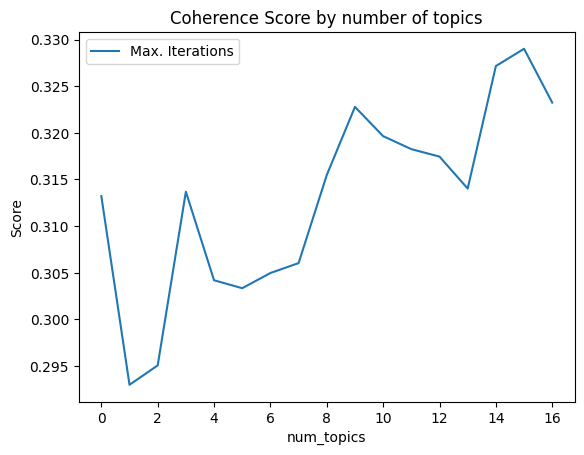

Coherence Score:  0.3290055097606999


# Conclussions 

Here I want to make some interpretations are comments with regards to this notebook.

In [33]:

# Visualise results: K = 3


# parameters['Score'] = coherence_values
# parameters.to_csv("gridsearch_gensim_1.csv",  index = False)
parameters.reset_index(drop = True)
print('Coherence Score: ', max(parameters['Score']))

hp = parameters.iloc[parameters['Score'].idxmax()]

data['tokens'] = data.lemmatized.values.tolist()
                                
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
data['tokens'] = list(sent_to_words(data['tokens']))
                                
# Remove lvl2 stopwords: 
stop_words_new = copy.deepcopy(stop_words)
stop_words_new.extend(extras)
                                    
data['tokens'] = remove_stopwords(data['tokens'], stop_words_new)
                                
# Remove documents with 3 words or less of length 4:
data = data[data['tokens'].map(len) > 4]
                                
# Group by author
data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
data['tokens'].astype(str)
author = data.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
author['tokens'] = list(sent_to_words(author['tokens']))
                                
# Filter extremes
id2word = Dictionary(author['tokens'], prune_at = 1000000)
id2word.filter_extremes(no_below = 2, no_above = 0.99, keep_n = None)
                                
# Create Corpus
texts = list(sent_to_words(author['tokens']))
                                
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
                        
model = LdaMulticore(corpus = corpus, eta = hp['eta'], alpha = hp['alpha'], num_topics = 3, id2word = id2word, iterations = 100, random_state = 10,
                                            workers = 5)

# model_list.append(model)
# coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
# coherence_values.append(coherencemodel.get_coherence())

print(model.print_topics())
print('')
print('')

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.006232  0.010417       1        1  41.636063
1     -0.006978 -0.010032       2        1  30.489096
0      0.013209 -0.000385       3        1  27.874841, topic_info=            Term         Freq        Total Category  logprob  loglift
143     mostoles   598.000000   598.000000  Default  30.0000  30.0000
10    estudiante  1052.000000  1052.000000  Default  29.0000  29.0000
151       master  1791.000000  1791.000000  Default  28.0000  28.0000
341       acabar   388.000000   388.000000  Default  27.0000  27.0000
572        clase  1174.000000  1174.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
22         venir   124.018644   431.778632   Topic3  -6.1946   0.0300
1490       plaza   118.382236   384.666499   Topic3  -6.2411   0.0990
65      trabajar   154.604752  1054.281716   Topic3  -5.9741  -0.6423
37        ayudar   126.395349   498.342591   Topic3  -6.1756  -0.0944
746     personar   120.321351   531.756934   Topic3  -6.2248  -0.2086

[273 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
341       1  0.337040     acabar
341       2  0.177525     acabar
341       3  0.483691     acabar
130       1  0.548691  actividad
130       2  0.304828  actividad
...     ...       ...        ...
762       2  0.312696     volver
762       3  0.170010     volver
5147      1  0.212523     walter
5147      2  0.212523     walter
5147      3  0.637568     walter

[606 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [45]:
# Code to check quicly the possible quality of the application. 

""" 

This code reflects:

You will have indicated the step by numeric definition (1., 2., etc) in a # comment.
The hipermarameters that are adjusted will be commented (#) in the same line they're used. 

"""

# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'hacer', 'ir', 'do', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
# puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver,
extras = ['seguro', 'bueno', 'realizar', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import copy

# Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
def remove_stopwords(texts, stop_words_new):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]

# Function replicating sklearn pipeline gridsearch
def gensim_gridsearch(corpus):
    
    # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
    for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
      for eta in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
        for num_topics in range(10, 11):
          parameters.loc[-1] = [alpha, eta, num_topics]
          parameters.index = parameters.index + 1
                                
          model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 50, random_state = 10,
                                                    workers = 5)
                                
          model_list.append(model)
          coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
          coherence_values.append(coherencemodel.get_coherence())
                                
          print(alpha, eta, num_topics)
                               
        
    parameters['Score'] = coherence_values
    # parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

    return model_list, coherence_values, parameters


In [37]:

# Visualise results: K = 10

                        
model = LdaMulticore(corpus = corpus, eta = hp['eta'], alpha = hp['alpha'], num_topics = 10, id2word = id2word, iterations = 100, random_state = 10,
                                            workers = 5)

# model_list.append(model)
# coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
# coherence_values.append(coherencemodel.get_coherence())

for i in model.print_topics():
  print('')
  print('topic 1' + str(i))
  print('')

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)
vis


Coherence Score:  0.3290055097606999

topic 1(0, '0.007*"master" + 0.005*"estudiante" + 0.004*"clase" + 0.003*"mostoles" + 0.003*"contar" + 0.003*"derecho" + 0.003*"examen" + 0.003*"jornada" + 0.003*"publico" + 0.003*"deber"')


topic 1(1, '0.010*"master" + 0.004*"trabajar" + 0.004*"clase" + 0.004*"carrera" + 0.003*"semana" + 0.003*"estudiante" + 0.003*"sacar" + 0.003*"partir" + 0.002*"mostoles" + 0.002*"hora"')


topic 1(2, '0.008*"master" + 0.006*"trabajar" + 0.004*"estudiante" + 0.003*"clase" + 0.003*"semana" + 0.003*"examen" + 0.003*"contar" + 0.003*"derecho" + 0.003*"online" + 0.003*"jornada"')


topic 1(3, '0.006*"clase" + 0.006*"master" + 0.006*"estudiante" + 0.004*"contar" + 0.004*"online" + 0.003*"examen" + 0.003*"publico" + 0.003*"trabajar" + 0.002*"programar" + 0.002*"presencial"')


topic 1(4, '0.007*"master" + 0.004*"clase" + 0.004*"trabajar" + 0.004*"estudiante" + 0.003*"personar" + 0.003*"contar" + 0.003*"examen" + 0.003*"publico" + 0.003*"deber" + 0.003*"participar"')



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.005810  0.005034       1        1  14.961738
8      0.006731 -0.005720       2        1  14.791036
3      0.003916  0.003286       3        1  14.124885
1      0.003128 -0.003612       4        1   9.672404
4      0.003138  0.001536       5        1   9.128678
6     -0.002475  0.004104       6        1   8.883277
5     -0.006033 -0.000067       7        1   7.634727
0     -0.006676 -0.000348       8        1   7.201939
7     -0.002368 -0.004099       9        1   6.860052
9     -0.005169 -0.000114      10        1   6.741265, topic_info=           Term         Freq        Total Category  logprob  loglift
143    mostoles   478.000000   478.000000  Default  30.0000  30.0000
572       clase   964.000000   964.000000  Default  29.0000  29.0000
151      master  1506.000000  1506.000000  Default  28.0000  28.0000
598      contar   613.000000   613.000000  Default  27.0000  27.0000
10   estudiante   875.000000   875.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
22        venir    24.852953   358.271120  Topic10  -6.3825   0.0286
381     ciencia    24.623111   365.806116  Topic10  -6.3918  -0.0015
37       ayudar    24.589413   409.518847  Topic10  -6.3932  -0.1157
297       deber    25.141291   488.258039  Topic10  -6.3710  -0.2694
180     publico    24.618281   482.272016  Topic10  -6.3920  -0.2781

[775 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
6670      1  0.080316     ab
6670      2  0.160633     ab
6670      3  0.080316     ab
6670      4  0.080316     ab
6670      5  0.080316     ab
...     ...       ...    ...
7902      6  0.103681  whats
7902      7  0.103681  whats
7902      8  0.103681  whats
7902      9  0.103681  whats
7902     10  0.103681  whats

[4593 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 4, 2, 5, 7, 6, 1, 8, 10])

In [44]:

# Visualise results: K = 10

                        
model = LdaMulticore(corpus = corpus, eta = hp['eta'], alpha = hp['alpha'], num_topics = 15, id2word = id2word, iterations = 100, random_state = 10,
                                            workers = 5)

# model_list.append(model)
# coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
# coherence_values.append(coherencemodel.get_coherence())

for i in model.print_topics():
  print('')
  print('topic 1' + str(i))
  print('')

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)
vis



topic 1(0, '0.006*"master" + 0.004*"estudiante" + 0.004*"clase" + 0.003*"mostoles" + 0.003*"contar" + 0.003*"derecho" + 0.002*"examen" + 0.002*"publico" + 0.002*"jornada" + 0.002*"carrera"')


topic 1(1, '0.008*"master" + 0.004*"clase" + 0.004*"trabajar" + 0.003*"carrera" + 0.003*"estudiante" + 0.003*"semana" + 0.002*"partir" + 0.002*"sacar" + 0.002*"hora" + 0.002*"grupo"')


topic 1(2, '0.007*"master" + 0.005*"trabajar" + 0.003*"estudiante" + 0.003*"clase" + 0.003*"semana" + 0.003*"examen" + 0.003*"online" + 0.002*"derecho" + 0.002*"jornada" + 0.002*"contar"')


topic 1(3, '0.005*"master" + 0.005*"clase" + 0.005*"estudiante" + 0.004*"online" + 0.003*"contar" + 0.003*"publico" + 0.003*"trabajar" + 0.003*"examen" + 0.002*"programar" + 0.002*"presencial"')


topic 1(4, '0.006*"master" + 0.004*"clase" + 0.003*"trabajar" + 0.003*"estudiante" + 0.003*"personar" + 0.003*"contar" + 0.003*"examen" + 0.002*"publico" + 0.002*"participar" + 0.002*"deber"')


topic 1(5, '0.006*"master" + 0.004*"c

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.005119 -0.001686       1        1  10.842446
2      0.004630 -0.003172       2        1  10.143367
8      0.004481  0.005580       3        1   9.919282
3      0.003010  0.000017       4        1   9.742984
12     0.001838 -0.002180       5        1   7.858536
11    -0.001226 -0.000785       6        1   6.174640
10    -0.002833 -0.001512       7        1   5.660201
6     -0.001860 -0.001938       8        1   5.396696
4      0.001294 -0.001254       9        1   5.381202
14     0.000789  0.001043      10        1   5.186267
7     -0.002306  0.004769      11        1   4.990171
9     -0.004222  0.000038      12        1   4.768440
1      0.001412  0.001706      13        1   4.761118
5     -0.004663 -0.000566      14        1   4.627861
0     -0.005462 -0.000061      15        1   4.546789, topic_info=           Term         Freq        Total Category  logprob  loglift
143    mostoles   431.000000   431.000000  Default  30.0000  30.0000
151      master  1354.000000  1354.000000  Default  29.0000  29.0000
572       clase   867.000000   867.000000  Default  28.0000  28.0000
10   estudiante   782.000000   782.000000  Default  27.0000  27.0000
222     carrera   441.000000   441.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
58      cambiar    15.823996   360.647383  Topic15  -6.4402  -0.0356
37       ayudar    15.665259   361.620001  Topic15  -6.4502  -0.0484
65     trabajar    21.701008   782.311296  Topic15  -6.1243  -0.4941
128       grupo    15.684389   393.649436  Topic15  -6.4490  -0.1320
500      online    16.795356   499.374457  Topic15  -6.3806  -0.3015

[1112 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
6670      1  0.072767     ab
6670      2  0.072767     ab
6670      3  0.072767     ab
6670      4  0.072767     ab
6670      5  0.072767     ab
...     ...       ...    ...
7902     11  0.090013  whats
7902     12  0.090013  whats
7902     13  0.090013  whats
7902     14  0.090013  whats
7902     15  0.090013  whats

[8620 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 3, 9, 4, 13, 12, 11, 7, 5, 15, 8, 10, 2, 6, 1])

In [ ]:


# data = pd.read_pickle("/content/drive/MyDrive/TFM data/data_with_corrections.pkl")


# 5. Remove numbers
# --------------------------------------
data['text'] = data['correction'].str.replace('\d+', '')


# 6. Further cleaning before lemmatisation
# --------------------------------------
def corrector(text):     
    text = text.replace(' lumnos ', ' alumno ') 
    text = text.replace(' estudiante ', ' alumno ') # Synonims I think it's worth having them as the same word
    text = text.replace(' avda ', ' avenida ')
    text = text.replace(' info ', ' informacion ')
    text = text.replace(' uni ', ' universidad ')
    text = text.replace(' almerio ', ' almeria ')
    text = text.replace(' estudio ', ' estudiar ')
    text = text.replace(' cambier ', ' cambiar ')
    text = text.replace(' como ', '')
    text = text.replace(' para ', '')
    text = text.replace(' parte ', '')
    text = text.replace(' sobre ', '')
    text = text.replace(' del ', '')
    text = text.replace(' nada ', '')
    
    return text

data['text'] = data['text'].swifter.apply(corrector)


# 7. Lemmatisation
# --------------------------------------
# The purpose of this code is to lemmatize (Convert to dictionary form) the words in each document, keeping the same format

# You need to run the code below before in order to be able to load es_core_news_sm.
# !python -m spacy download es_core_news_sm
# nlp = spacy.load('es_core_news_sm', exclude = ['derechos', 'expres', 'ademas', 'traves', 'adios', 'para', 'casar'], 
#                  disable = ['derechos', 'expres', 'ademas', 'traves', 'adios', 'para', 'casar'])

!python -m spacy download es
nlp = spacy.load('es')

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

data['lemmatized'] = data['text'].swifter.apply(lambda x: lemmatizer(x)) 


from gensim.parsing.preprocessing import strip_multiple_whitespaces
data['lemmatized'] = data['lemmatized'].apply(strip_multiple_whitespaces)

import unidecode
data['lemmatized'] = data['lemmatized'].apply(unidecode.unidecode)
data['lemmatized'] = data['lemmatized'].apply(gensim.utils.deaccent) # In case we apply both

# Be aware of the words that would change with lematization: titulo, grado, 

# 8. Stopwords work 
# --------------------------------------

# Find the list of stopwords

# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'do', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
# puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver,
extras = ['seguro', 'cursar', 'bueno', 'realizar', 'titulo', 'clase', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']


In [ ]:
# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'do', 'apostol', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend([ 'oh', 'um', 'informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])


In [ ]:
data[data['lemmatized'].str.contains('apostol') & data['lemmatized'].str.contains('apostol')]['lemmatized'][122]
data[data['lemmatized'].str.contains('apostol')]['text'][122]

In [ ]:
# !python -m spacy download es_core_news_sm
# !python -m spacy download es_core_web_sm
# !python -m spacy download es

In [ ]:
# import spacy
# import es_core_web_sm
# nlp = es_core_news_sm.load()

# !pip3 install https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-2.2.0/es_core_news_sm-2.2.0.tar.gz


In [ ]:
# nlp = spacy.load('es')

In [ ]:
# spacy.load('es')

In [ ]:
# data[data['lemmatized'].str.contains('do')]['lemmatized']

In [ ]:

### Code to plot the cummulated TF-IDF unigram:
tf_vectorizer = CountVectorizer(stop_words = stop_words, lowercase = True, min_df = 0.0005, strip_accents = 'ascii')
# CountVectorizer

tf = tf_vectorizer.fit_transform(data["lemmatized"])
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 60 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True)#.plot(kind = 'barh', title = 'Count Unigram')

# pablar
# personar
# Alomillor to millora, osea this are not completely bad news to be honest

## Trainning

In [ ]:
# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'do', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
# puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver,
extras = ['bueno', 'acabar', 'um', 'oh', 'seguro', 'cursar', 'bueno', 'realizar', 'titulo', 'clase', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']


In [ ]:
# Code to check quicly the possible quality of the application. 

""" 

This code reflects:

You will have indicated the step by numeric definition (1., 2., etc) in a # comment.
The hipermarameters that are adjusted will be commented (#) in the same line they're used. 

"""

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import copy

# Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
def remove_stopwords(texts, stop_words_new):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]


# Function replicating sklearn pipeline gridsearch
def gensim_gridsearch(data):
        
    coherence_values = []
    model_list = []
    parameters = pd.DataFrame(columns = ['alpha', 'eta', 'num_topics'])

    tokens = data
    tokens['tokens'] = tokens.lemmatized.values.tolist()
                 
    def sent_to_words(sentences):
      for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                 
    tokens['tokens'] = list(sent_to_words(tokens['tokens']))
    
    # Remove lvl2 stopwords: 
    stop_words_new = copy.deepcopy(stop_words)     
    stop_words_new.extend(extras)  
    tokens['tokens'] = remove_stopwords(tokens['tokens'], stop_words_new)
    
    # Remove documents with 3 words or less of length 4:
    tokens = tokens[tokens['tokens'].map(len) > 4]
    
    # Group by author
    tokens['tokens'] = tokens['tokens'].apply(lambda x: ' '.join(x))
    tokens['tokens'].astype(str)
    author = tokens.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
    author['tokens'] = list(sent_to_words(author['tokens']))
    
    # Filter extremes
    id2word = Dictionary(author['tokens'], prune_at = 1000000)
    id2word.filter_extremes(no_below = 2, no_above = 0.95, keep_n = None)
    
    # Create Corpus
    texts = list(sent_to_words(author['tokens']))
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
    for alpha in [0.25, 0.5, 0.75]:
      for eta in [0.25, 0.5, 0.75]:
        for num_topics in range(2, 19):
          parameters.loc[-1] = [alpha, eta, num_topics]
          parameters.index = parameters.index + 1
                                
          model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
                                                    workers = 5)
                                
          model_list.append(model)
          coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
          coherence_values.append(coherencemodel.get_coherence())
                                
          print(alpha, eta, num_topics)
                               
        
    parameters['Score'] = coherence_values
    # parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

    return model_list, coherence_values, parameters


In [ ]:

import warnings
warnings.filterwarnings("ignore")

model_list, coherence_values, parameters = gensim_gridsearch(data = data)


In [ ]:

# import warnings
# warnings.filterwarnings("ignore")

# model_list, coherence_values, parameters = gensim_gridsearch(data = data)

# pd.to_pickle(data, "/content/drive/MyDrive/TFM data/data_with_corrections.pkl")



In [ ]:
"""

1. group by num_topics max score 



"""



# print(parameters.iloc[parameters['Score'].idxmax()])

parameters.groupby('num_topics')['Score'].max().plot(kind = 'barh', title = 'Main Hashtags')

# 4 and 17 

## Interpreting

In [ ]:
(
    ggplot(results)
    + aes(x = "component", y = "value", color = "variable")
    + labs(
        title = "Maximum Log-likelihood score for each k components",
        subtitle = "dsa ceew cwe",
        caption = "Pere Fuster - UC3M",
        x = "Number of Topics",
        y = "Log-likelihood",
        color = "Prior Distributions")
    + geom_point(size = 4)
)

In [ ]:

# parameters['Score'] = coherence_values
# parameters.to_csv("gridsearch_gensim_1.csv",  index = False)
parameters.reset_index(drop = True)
print('Coherence Score: ', max(parameters['Score']))

hp = parameters.iloc[parameters['Score'].idxmax()]

data['tokens'] = data.lemmatized.values.tolist()
                                
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
data['tokens'] = list(sent_to_words(data['tokens']))
                                
# Remove lvl2 stopwords: 
stop_words_new = copy.deepcopy(stop_words)
stop_words_new.extend(extras)
                                    
data['tokens'] = remove_stopwords(data['tokens'], stop_words_new)
                                
# Remove documents with 3 words or less of length 4:
data = data[data['tokens'].map(len) > 4]
                                
# Group by author
data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
data['tokens'].astype(str)
author = data.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
author['tokens'] = list(sent_to_words(author['tokens']))
                                
# Filter extremes
id2word = Dictionary(author['tokens'], prune_at = 1000000)
id2word.filter_extremes(no_below = 2, no_above = 0.99, keep_n = None)
                                
# Create Corpus
texts = list(sent_to_words(author['tokens']))
                                
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
                        
model = LdaMulticore(corpus = corpus, eta = hp['eta'], alpha = hp['alpha'], num_topics = hp['num_topics'], id2word = id2word, iterations = 70, random_state = 10,
                                            workers = 5)

# model_list.append(model)
# coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
# coherence_values.append(coherencemodel.get_coherence())


In [ ]:

# Visualise results

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)
vis

# watchouts: 
# oh, um, gradar
# possible new stopwords: puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver, 

# LDA without text correction

In [ ]:

"""

PRE-PROCESS: 

0. Get the unduplicated / non-retweeted tweets. 


NON-TUNED PRE-PROCESSING STEPS:

1. Remove the hashtags, links and shares

2. Lowcase 

3. Remove punctuation 

4. Remove accents 

5. Remove numbers (TBC)

6. Lemmatise 

7. Make some corrections uncovered above


TUNED STEPS:

8. Remove stopwords (TBC properly) 

9. Remove short tweets 

10. Group by author and gridsearch best LDA hyperparameters.  

"""


import warnings
warnings.filterwarnings("ignore")


# 1. Remove links, hashtags and mentions
# --------------------------------------

def hashtag(txt):
    
    # Remove hashtags
    result = ' '.join(word for word in txt.split(' ') if not word.startswith('#'))
    
    # Remove shares
    result = ' '.join(word for word in result.split(' ') if not word.startswith('@'))
    # check if this doesn't work well use: result = re.sub(r'@\S+', '', result)
        
    # Remove some jajajas
    result = ' '.join(word for word in result.split(' ') if 'jaja' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'jj' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'haha' not in word.lower())

    # Remove links
    result = re.sub(r'http\S+', '', result)

    # Further work with potential remainings
    result = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", result)
    result = re.sub(r'[¿“‘?’"„“<>,!"]', "", result)
    result = re.sub('!', "", result)
    
    return result

    
data['text'] = data['text'].apply(hashtag)


# 2. Lowcase and make corrections
# --------------------------------------

data['text'] = data['text'].apply(np.char.lower)



# 3. Remove punctuation from text
# --------------------------------------

from gensim.parsing.preprocessing import strip_punctuation
data['text'] = data['text'].apply(strip_punctuation)



# 4. Correct some misspallings and Remove accents from text
# --------------------------------------



In [ ]:


# 5. Remove numbers
# --------------------------------------
data['text'] = data['text'].str.replace('\d+', '')


# 6. Further cleaning before lemmatisation
# --------------------------------------

def corrector(text):     
    text = text.replace(' lumnos ', ' alumno ') 
    text = text.replace(' estudiante ', ' alumno ') # Synonims I think it's worth having them as the same word
    text = text.replace(' avda ', ' avenida ')
    text = text.replace(' info ', ' informacion ')
    text = text.replace(' uni ', ' universidad ')
    text = text.replace(' almerio ', ' almeria ')
    text = text.replace(' estudio ', ' estudiar ')
    text = text.replace(' cambier ', ' cambiar ')
    text = text.replace(' como ', '')
    text = text.replace(' para ', '')
    text = text.replace(' parte ', '')
    text = text.replace(' sobre ', '')
    text = text.replace(' del ', '')
    text = text.replace(' nada ', '')
    
    return text

import swifter
data['text'] = data['text'].swifter.apply(corrector)



# 7. Lemmatisation
# --------------------------------------
# The purpose of this code is to lemmatize (Convert to dictionary form) the words in each document, keeping the same format

# You need to run the code below before in order to be able to load es_core_news_sm.
# !python -m spacy download es_core_news_sm
# nlp = spacy.load('es_core_news_sm', exclude = ['derechos', 'expres', 'ademas', 'traves', 'adios', 'para', 'casar'], 
#                  disable = ['derechos', 'expres', 'ademas', 'traves', 'adios', 'para', 'casar'])

!python -m spacy download es
nlp = spacy.load('es')

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

data['lemmatized'] = data['text'].swifter.apply(lambda x: lemmatizer(x)) 


from gensim.parsing.preprocessing import strip_multiple_whitespaces
data['lemmatized'] = data['lemmatized'].apply(strip_multiple_whitespaces)

import unidecode
data['lemmatized'] = data['lemmatized'].apply(unidecode.unidecode)
data['lemmatized'] = data['lemmatized'].apply(gensim.utils.deaccent) # In case we apply both

# Be aware of the words that would change with lematization: titulo, grado, 

# 8. Stopwords work 
# --------------------------------------

# Find the list of stopwords

# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'do', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
# puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver,
extras = ['oh', 'um', 'puto', 'seguro', 'cursar', 'bueno', 'realizar', 'titulo', 'clase', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']


## Trainning

In [ ]:
# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['urgir', 'do', 'apostol', 'interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['oh', 'um', 'informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])


In [ ]:
# import spacy
# import es_core_web_sm
# nlp = es_core_news_sm.load()

!pip3 install https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-2.2.0/es_core_news_sm-2.2.0.tar.gz


In [ ]:

### Code to plot the cummulated TF-IDF unigram:
tf_vectorizer = CountVectorizer(stop_words = stop_words, lowercase = True, min_df = 0.0005, strip_accents = 'ascii')
# CountVectorizer

tf = tf_vectorizer.fit_transform(data["lemmatized"])
tfidf = pd.DataFrame(tf.toarray())
tfidf.columns = tf_vectorizer.get_feature_names()
tfidf[tfidf.columns]

n = 60 # Define length of the graph
tfidf.apply(np.mean).sort_values(ascending = False)[0:n].sort_values(ascending = True)#.plot(kind = 'barh', title = 'Count Unigram')

# pablar
# personar
# Alomillor to millora, osea this are not completely bad news to be honest

In [ ]:
# Code to check quicly the possible quality of the application. 

""" 

This code reflects:

You will have indicated the step by numeric definition (1., 2., etc) in a # comment.
The hipermarameters that are adjusted will be commented (#) in the same line they're used. 

"""

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import copy

# Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
def remove_stopwords(texts, stop_words_new):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]


# Function replicating sklearn pipeline gridsearch
def gensim_gridsearch(data):
        
    coherence_values = []
    model_list = []
    parameters = pd.DataFrame(columns = ['alpha', 'eta', 'num_topics'])

    tokens = data
    tokens['tokens'] = tokens.lemmatized.values.tolist()
                 
    def sent_to_words(sentences):
      for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                 
    tokens['tokens'] = list(sent_to_words(tokens['tokens']))
    
    # Remove lvl2 stopwords: 
    stop_words_new = copy.deepcopy(stop_words)     
    stop_words_new.extend(extras)  
    tokens['tokens'] = remove_stopwords(tokens['tokens'], stop_words_new)
    
    # Remove documents with 3 words or less of length 4:
    tokens = tokens[tokens['tokens'].map(len) > 4]
    
    # Group by author
    tokens['tokens'] = tokens['tokens'].apply(lambda x: ' '.join(x))
    tokens['tokens'].astype(str)
    author = tokens.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
    author['tokens'] = list(sent_to_words(author['tokens']))
    
    # Filter extremes
    id2word = Dictionary(author['tokens'], prune_at = 1000000)
    id2word.filter_extremes(no_below = 2, no_above = 0.95, keep_n = None)
    
    # Create Corpus
    texts = list(sent_to_words(author['tokens']))
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
    for alpha in [0.25, 0.5, 0.75]:
      for eta in [0.25, 0.5, 0.75]:
        for num_topics in range(2, 21):
          parameters.loc[-1] = [alpha, eta, num_topics]
          parameters.index = parameters.index + 1
                                
          model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
                                                    workers = 5)
                                
          model_list.append(model)
          coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
          coherence_values.append(coherencemodel.get_coherence())
                                
          print(alpha, eta, num_topics)
                               
        
    parameters['Score'] = coherence_values
    # parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

    return model_list, coherence_values, parameters


In [ ]:

import warnings
warnings.filterwarnings("ignore")

model_list, coherence_values, parameters = gensim_gridsearch(data = data)
# parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

In [ ]:
# # Code to check quicly the possible quality of the application. 

# """ 

# This code reflects:

# You will have indicated the step by numeric definition (1., 2., etc) in a # comment.

# The hipermarameters that are adjusted will be commented (#) in the same line they're used. 

# """

# from gensim.corpora import Dictionary
# from gensim.models.ldamulticore import LdaMulticore
# from gensim.models.coherencemodel import CoherenceModel
# import copy

# # Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
# def remove_stopwords(texts, stop_words_new):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]


# # Function replicating sklearn pipeline gridsearch
# def gensim_gridsearch(data):
    
#     """
#     HYPERPARAMETER CHOICE PROCESS: 
    
#     Best Model: Model that makes more sense and groups the data well. This is something that is done by looking ate
#     the results of the model, but is correlated with Likelihood/Pplexity and Coherence Score gain functions. So, these
#     are utilised to filter out LDA (Not preprocessing) hp values that are unlikely to reflect well the hidden topics. 
    
#     The objective is to break the problem into first break it by preprocessing decision, and for each reduce the 
#     k topics gridsearch based on the coherence score. 
    
#     Once this is sorted, a more thorough gridsearch will be undertaken to truly identify the best values of alpha and 
#     beta, and which pipeline generates the best quality insight. 
    
#     """
    
#     coherence_values = []
#     model_list = []
#     parameters = pd.DataFrame(columns = ['i_stopwords', 'cutoff', 'alpha', 'eta', 'no_below', 'no_above', 'num_topics'])
    
#     # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
#     for i_stopwords in ['yes']: # Preprocessing HP1: Consider extra stopverbs: Yes/No (Per a mi es un yes)
#         for cutoff in [5]: # Preprocessing  HP2: 
#             for no_below in [4]: # Preprocessing  HP3: Minimum of the tweets for a word to be considered
#                 for no_above in [1]:  # Preprocessing  HP4: Maximum % if tweet for a word to be considered  
#                     for alpha in [0.25, 0.5, 0.75]: # LDA HP Alpha: Prior 
#                         for eta in [0.25, 0.5, 0.75]: # LDA HP Eta: Prior
#                             for num_topics in range(2, 5): # LDA HP K: Number of topics
                                
#                                 parameters.loc[-1] = [i_stopwords, cutoff, alpha, eta, no_below, no_above, num_topics]
#                                 parameters.index = parameters.index + 1

#                                 tokens = data
#                                 tokens['tokens'] = tokens.lemmatized.values.tolist()
                                
#                                 def sent_to_words(sentences):
#                                     for sentence in sentences:
#                                         yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
#                                 tokens['tokens'] = list(sent_to_words(tokens['tokens']))
                                
#                                 # Remove lvl2 stopwords: 
#                                 stop_words_new = copy.deepcopy(stop_words)
                                
#                                 if i_stopwords == 'yes':     
#                                     stop_words_new.extend(extras)
                                    
#                                 tokens['tokens'] = remove_stopwords(tokens['tokens'], stop_words_new)
                                
#                                 # Remove documents with 3 words or less of length 4:
#                                 tokens = tokens[tokens['tokens'].map(len) > cutoff]
                                
#                                 # Group by author
#                                 tokens['tokens'] = tokens['tokens'].apply(lambda x: ' '.join(x))
#                                 tokens['tokens'].astype(str)
#                                 author = tokens.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
#                                 author['tokens'] = list(sent_to_words(author['tokens']))
                                
#                                 # Filter extremes
#                                 id2word = Dictionary(author['tokens'], prune_at = 1000000)
#                                 id2word.filter_extremes(no_below = no_below, no_above = no_above, keep_n = None)
                                
#                                 # Create Corpus
#                                 texts = list(sent_to_words(author['tokens']))
                                
#                                 # Term Document Frequency
#                                 corpus = [id2word.doc2bow(text) for text in texts]
                                
#                                 model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
#                                                     workers = 5)
                                
#                                 model_list.append(model)
#                                 coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
#                                 coherence_values.append(coherencemodel.get_coherence())
                                
#                                 print(i_stopwords, cutoff, alpha, eta, no_below, no_above, num_topics)
                               
        
#     parameters['Score'] = coherence_values
#     parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

#     return model_list, coherence_values, parameters


In [ ]:

# import warnings
# warnings.filterwarnings("ignore")

# model_list, coherence_values, parameters = gensim_gridsearch(data = data)

# pd.to_pickle(data, "/content/drive/MyDrive/TFM data/data_with_corrections.pkl")


In [ ]:

# parameters['Score'] = coherence_values
# parameters.to_csv("gridsearch_gensim_1.csv",  index = False)
parameters.reset_index(drop = True)
print('Coherence Score: ', max(parameters['Score']))

hp = parameters.iloc[parameters['Score'].idxmax()]

data['tokens'] = data.lemmatized.values.tolist()
                                
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
data['tokens'] = list(sent_to_words(data['tokens']))
                                
# Remove lvl2 stopwords: 
stop_words_new = copy.deepcopy(stop_words)
stop_words_new.extend(extras)
                                    
data['tokens'] = remove_stopwords(data['tokens'], stop_words_new)
                                
# Remove documents with 3 words or less of length 4:
data = data[data['tokens'].map(len) > 4]
                                
# Group by author
data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
data['tokens'].astype(str)
author = data.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
author['tokens'] = list(sent_to_words(author['tokens']))
                                
# Filter extremes
id2word = Dictionary(author['tokens'], prune_at = 1000000)
id2word.filter_extremes(no_below = 2, no_above = 0.99, keep_n = None)
                                
# Create Corpus
texts = list(sent_to_words(author['tokens']))
                                
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
                        
model = LdaMulticore(corpus = corpus, eta = 0.5, alpha = 0.5, num_topics = 17, id2word = id2word, iterations = 70, random_state = 10,
                                            workers = 5)

# model_list.append(model)
# coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
# coherence_values.append(coherencemodel.get_coherence())


Coherence Score:  0.3153630546103583


In [ ]:
parameters.groupby('num_topics')['Score'].max().plot(kind = 'barh', title = 'Main Hashtags')

In [ ]:

# Visualise results

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary = model.id2word)
vis

# watchouts: 
# oh, um, gradar
# possible new stopwords: puto, cuenta-contar, bueno, mostoles, cursar-curso, nada (transformed to nadar...), volver, 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.016082  0.007955       1        1  22.432643
16     0.018524 -0.007428       2        1  10.984357
15     0.003802  0.005535       3        1   9.598410
8      0.003691  0.012755       4        1   6.188033
9      0.004008  0.001892       5        1   5.767814
3      0.003456 -0.003139       6        1   5.462791
12     0.007186 -0.011808       7        1   4.562837
14    -0.007305  0.006700       8        1   4.347561
0      0.002361 -0.004202       9        1   3.835514
1     -0.006792  0.000258      10        1   3.824387
13    -0.012147 -0.002141      11        1   3.623771
2     -0.000568  0.003029      12        1   3.584644
4     -0.007082 -0.006477      13        1   3.290042
11    -0.004012  0.000987      14        1   3.249127
5     -0.013615 -0.001213      15        1   3.207130
6     -0.004258  0.001545      16        1   3.121143
7     -0.003332 -0.004248      17        1   2.919797, topic_info=         Term        Freq       Total Category  logprob  loglift
138    master  642.000000  642.000000  Default  30.0000  30.0000
7     nombrar  649.000000  649.000000  Default  29.0000  29.0000
694    firmar  480.000000  480.000000  Default  28.0000  28.0000
5     cambiar  688.000000  688.000000  Default  27.0000  27.0000
156  mostoles  330.000000  330.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
805    online    9.468605  391.717287  Topic17  -6.1151  -0.1889
167      hora    9.171592  465.612854  Topic17  -6.1470  -0.3936
838    semana    7.942184  365.066833  Topic17  -6.2909  -0.2942
223  trabajar    8.158786  501.252155  Topic17  -6.2640  -0.5844
477    contar    6.818612  405.046742  Topic17  -6.4435  -0.5507

[1210 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
5223      1  0.131310    ab
5223      2  0.131310    ab
5223      3  0.131310    ab
5223     10  0.131310    ab
5673      1  0.192357   abc
...     ...       ...   ...
2350     16  0.057016  ylos
2126      1  0.124323  york
2126      2  0.124323  york
2126      3  0.124323  york
2126      6  0.124323  york

[7964 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 17, 16, 9, 10, 4, 13, 15, 1, 2, 14, 3, 5, 12, 6, 7, 8])

In [ ]:
data


IndexError: ignored

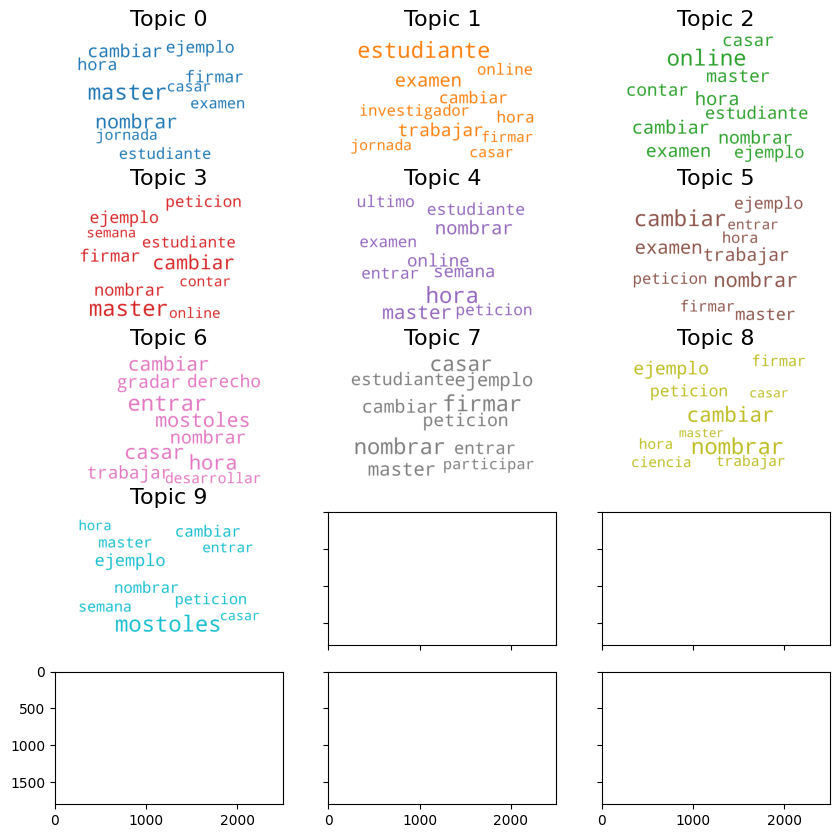

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords = stop_words,
                  background_color = 'white',
                  width = 2500,
                  height = 1800,
                  max_words = 10,
                  colormap = 'tab10',
                  color_func = lambda *args, **kwargs: cols[i],
                  prefer_horizontal = 1.0)

topics = model.show_topics(formatted = False)

fig, axes = plt.subplots(5, 3, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x = 0, y = 0)
plt.tight_layout()
plt.show()


In [ ]:

"""

PRE-PROCESS: 

0. Get the unduplicated / non-retweeted tweets. 


NON-TUNED PRE-PROCESSING STEPS:

1. Remove the hashtags, links and shares

2. Lowcase 

3. Remove punctuation 

4. Remove accents 

5. Remove numbers (TBC)

6. Lemmatise 

7. Make some corrections uncovered above


TUNED STEPS:

8. Remove stopwords (TBC properly) 

9. Remove short tweets 

10. Group by author and gridsearch best LDA hyperparameters.  

"""


# 1. Remove links, hashtags and mentions
# --------------------------------------

def hashtag(txt):
    
    # Remove hashtags
    result = ' '.join(word for word in txt.split(' ') if not word.startswith('#'))
    
    # Remove shares
    result = ' '.join(word for word in result.split(' ') if not word.startswith('@'))
    
    # Remove some jajajas
    result = ' '.join(word for word in result.split(' ') if 'jaja' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'jj' not in word.lower())
    result = ' '.join(word for word in result.split(' ') if 'haha' not in word.lower())

    # Remove links
    result = re.sub(r'http\S+', '', result)

    # Further work with potential remainings
    result = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", result)
    result = re.sub(r'[¿“‘?’"„“<>,!"]', "", result)
    result = re.sub('!', "", result)
    
    return result

    
data['text'] = data['text'].apply(hashtag)


# 2. Lowcase 
# --------------------------------------

data['text'] = data['text'].apply(np.char.lower)



# 3. Remove punctuation from text
# --------------------------------------

from gensim.parsing.preprocessing import strip_punctuation
data['text'] = data['text'].apply(strip_punctuation)



# 4. Remove accents from text
# --------------------------------------

import unidecode
data['text'] = data['text'].apply(unidecode.unidecode)
data['text'] = data['text'].apply(gensim.utils.deaccent) # In case we apply both 



# 5. Remove numbers
# --------------------------------------

data['text'] = data['text'].str.replace('\d+', '')



# 6. Lemmatisation
# --------------------------------------
# The purpose of this code is to lemmatize (Convert to dictionary form) the words in each document, 
# keeping the same format

nlp = spacy.load('es_core_news_sm', exclude = ['derechos', 'expres', 'ademas', 'traves', 'adios'], disable = ['derechos', 'expres', 'ademas', 'traves', 'adios'])

def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

data['lemmatized'] = data['text'].apply(lambda x: lemmatizer(x)) 



# 7. Further cleaning
# --------------------------------------

def corrector(text):     
    text = text.replace(' lumnos ', ' alumno ') 
    text = text.replace(' estudiante ', ' alumno ') # Synonims I think it's worth having them as the same word
    text = text.replace(' avda ', ' avenida ')
    text = text.replace(' info ', ' informacion ')
    text = text.replace(' uni ', ' universidad ')
    text = text.replace(' almerio ', ' almeria ')
    text = text.replace(' estudio ', ' estudiar ')
    text = text.replace(' cambier ', ' cambiar ')
    
    return text

data['lemmatized'] = data['lemmatized'].apply(corrector)

from gensim.parsing.preprocessing import strip_multiple_whitespaces
data['lemmatized'] = data['lemmatized'].apply(strip_multiple_whitespaces)



# 8. Stopwords work 
# --------------------------------------

# Find the list of stopwords

# Note that the removal depends on the library and will be part of each. 
stop_words = stopwords.words('spanish')
stop_words_extension = get_stop_words('es')
stop_words.extend(stop_words_extension)

# Remove accents from stopwords (I'll work with no accents anywhere, since we don't expect people to write always with accents) 
stop_words = [gensim.utils.deaccent(each_word) for each_word in stop_words]

stop_words.extend(['interesante', 'universidadjuancarlos', 'él', 'hala', 'juanca', 'reyjuancar', 'urjcritica', 'this', 'was', 'date', 'great', 'my', 'first', 'claro', 'queydondeestudiar2020', 'rey', 'juan', 'literalmente', 'universidadreyjuancarlo', 'universidadjuancarlos', 'lareyjuancarlos', 'universidadreyjuancarlos', 'universidadreyjuancarlo', 'urjc', 'gracia', 'gracias','ajjaj', 'xd', 'xdd', 'xdxd', 'Madrid', 'primero', 'segundo', 'tercero', 'cuarto', 'quinto', 'sexto', 'septimo', 'octavo', 't', 'a', 's', 'k', 'q', 'mas', 'tambien', 'ir', 'alla', 'cosa', 'iee', 'siquiera', 'in', 'the', 'of', 'ano', 'n', 'p', 'r', 'asi', 'coincidir', 'aa', 'decir', '¡', '¿', 'poder', 'podeis', 'estais', 'traves', 'alguno', 'buen', 'nosotrxs', 'bufff', 'buff', 'universitario', 'lol', 'omg', 'wtf', 'idk', 'fyi', 'tbh', 'lmao', 'asap', 'thanks', 'thank', 'thx', 
                'trav', 'bastante', 'muchisimo', 'muchisimos', 'muchisima', 'muchisimas', 'muchisimar', 'monton', 'habia', 'xe', 'jo', 'ops', 'ups', 'yupi', 'poca', 'poco', 'enhorabuena', 'incluso', 'igual', 'ahora', 'despu', 'pese', 'ser', 'cierto', 'haber', 'for', 'par', 'universidad', 'with', 'asimismo', 'carlos', 'universidad', 'iii', 'ser', 'entonces', 'madrid', 'tras', 'jo él', 'hacer', 'espán', 'noticia', 'as', 'periodico', 'diario', 'news', 'si', 'aca', 'mas', 'ademas', 'gracias', 'aqui', 'hola', 'saludos', 'hoy', 'co', 'bien', 'ver', 'dar', 'vosotrxs', 'wow', 'ahora', 'solo', 'todo', 'cualquier', 'cualquiera', 'pues', 'vez', 'mismo', 'evidentemente', 'uee', 'hey', 'hello', 'xvii', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xviii', 'ixx', 'xx', 'xxi', 
                'parte', 'normalmente', 'mil', 'adio', 'millon', '!', 'yosoyurjc', 'haced', 'hacerte', 'mientras', 'menos', 'después', 'despues', 'dias', 'cuyo', 'cuya', 'of', '_', 'aun', 'nunca', 'siempre', 'muchisima', 'dia', 'algun', 'pon', 'sino', 'mejor', 'poca', 'peor', 'ano', 'nuevo', '200', '-', 'uee', 'href', 'uno', 'dos', 'tres', 'espán', 'medal él', 'desmontar él', 'jo él', 'joder', 'char él', 'queydondeestudiar', 'mer él', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez', 'veintena', 'doce', 'docena', 'trece', 'veitiuno', 'cien', 'decena', 'x2', '–', 'https', 'http', 'rt', 'm', 'uc', 'alguien', 'cada', 'latest', 'tmb', 'via', 'tal', 'etc', 'etcetera', 'traves', 'ma', 'ahi', 'aqui', 'alli', 'alla', 'so', 'if', 'mmm', 'hmm', 'ja', 'cuidadosamente', 'quizas', 'quiza', 'nada', 'nunca', 'probablemente', 'mismisimo', 'totalmente', 'completamente'])

stop_words.extend(['informacion', 'titulo', 'alumno', 'estudiar', 'profesor', 'primerisimo', 'adema', 'yomequedoencasa'])

# Frequent words that add litle meaning: Hyperparameter in gridsearch
extras = ['seguro', 'realizar', 'titulo', 'clase', 'tener', 'necesitar', 'querer', 'abrir', 'agarrar', 'andar', 'caminar', 'buscar', 'caer', 'conocer', 'saber', 'hablar', 'tener', 'tomar', 'poner', 'dar', 'ir', 'decir', 'estar', 'ser', 'vivir', 'oir', 'poner', 'traer', 'sentir', 'ver', 'mirar', 'llegar', 'llevar', 'entender', 'oler', 'salir', 'comprender', 'rayar', 'tener', 'flipar', 'putear', 'darle', 'saber', 'pasar', 'poner', 'esperar', 'dejar', 'parecer', 'salir', 'seguir', 'creer', 'opinar', 'informacion', 'alumno']


# Further code saved

In [ ]:
# # Code to check quicly the possible quality of the application. 

# """ 

# This code reflects:

# You will have indicated the step by numeric definition (1., 2., etc) in a # comment.

# The hipermarameters that are adjusted will be commented (#) in the same line they're used. 

# """

# from gensim.corpora import Dictionary
# from gensim.models.ldamulticore import LdaMulticore
# from gensim.models.coherencemodel import CoherenceModel
# import copy

# # Function that will remove the stopwords indicated by the preprocessing hp i_stopwords
# def remove_stopwords(texts, stop_words_new):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_new] for doc in texts]


# # Function replicating sklearn pipeline gridsearch
# def gensim_gridsearch(data):
    
#     """
#     HYPERPARAMETER CHOICE PROCESS: 
    
#     Best Model: Model that makes more sense and groups the data well. This is something that is done by looking ate
#     the results of the model, but is correlated with Likelihood/Pplexity and Coherence Score gain functions. So, these
#     are utilised to filter out LDA (Not preprocessing) hp values that are unlikely to reflect well the hidden topics. 
    
#     The objective is to break the problem into first break it by preprocessing decision, and for each reduce the 
#     k topics gridsearch based on the coherence score. 
    
#     Once this is sorted, a more thorough gridsearch will be undertaken to truly identify the best values of alpha and 
#     beta, and which pipeline generates the best quality insight. 
    
#     """
    
#     coherence_values = []
#     model_list = []
#     parameters = pd.DataFrame(columns = ['i_stopwords', 'cutoff', 'alpha', 'eta', 'no_below', 'no_above', 'num_topics'])
    
#     # I would probably remove the symetric stuff... or give a value to it to be able to plot the results 
#     for i_stopwords in ['yes']: # Preprocessing HP1: Consider extra stopverbs: Yes/No (Per a mi es un yes)
#         for cutoff in [5]: # Preprocessing  HP2: 
#             for no_below in [4]: # Preprocessing  HP3: Minimum of the tweets for a word to be considered
#                 for no_above in [1]:  # Preprocessing  HP4: Maximum % if tweet for a word to be considered  
#                     for alpha in [0.25, 0.5, 0.75]: # LDA HP Alpha: Prior 
#                         for eta in [0.25, 0.5, 0.75]: # LDA HP Eta: Prior
#                             for num_topics in range(2, 5): # LDA HP K: Number of topics
                                
#                                 parameters.loc[-1] = [i_stopwords, cutoff, alpha, eta, no_below, no_above, num_topics]
#                                 parameters.index = parameters.index + 1

#                                 tokens = data
#                                 tokens['tokens'] = tokens.lemmatized.values.tolist()
                                
#                                 def sent_to_words(sentences):
#                                     for sentence in sentences:
#                                         yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
                                
#                                 tokens['tokens'] = list(sent_to_words(tokens['tokens']))
                                
#                                 # Remove lvl2 stopwords: 
#                                 stop_words_new = copy.deepcopy(stop_words)
                                
#                                 if i_stopwords == 'yes':     
#                                     stop_words_new.extend(extras)
                                    
#                                 tokens['tokens'] = remove_stopwords(tokens['tokens'], stop_words_new)
                                
#                                 # Remove documents with 3 words or less of length 4:
#                                 tokens = tokens[tokens['tokens'].map(len) > cutoff]
                                
#                                 # Group by author
#                                 tokens['tokens'] = tokens['tokens'].apply(lambda x: ' '.join(x))
#                                 tokens['tokens'].astype(str)
#                                 author = tokens.groupby('author_id')['tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
#                                 author['tokens'] = list(sent_to_words(author['tokens']))
                                
#                                 # Filter extremes
#                                 id2word = Dictionary(author['tokens'], prune_at = 1000000)
#                                 id2word.filter_extremes(no_below = no_below, no_above = no_above, keep_n = None)
                                
#                                 # Create Corpus
#                                 texts = list(sent_to_words(author['tokens']))
                                
#                                 # Term Document Frequency
#                                 corpus = [id2word.doc2bow(text) for text in texts]
                                
#                                 model = LdaMulticore(corpus = corpus, eta = eta, alpha = alpha, num_topics = num_topics, id2word = id2word, iterations = 40, random_state = 10,
#                                                     workers = 5)
                                
#                                 model_list.append(model)
#                                 coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
#                                 coherence_values.append(coherencemodel.get_coherence())
                                
#                                 print(i_stopwords, cutoff, alpha, eta, no_below, no_above, num_topics)
                               
        
#     parameters['Score'] = coherence_values
#     parameters.to_csv("gridsearch_gensim_2.csv",  index = False)

#     return model_list, coherence_values, parameters
